# Trabajo práctico N°1: FIUFIP

## Parte 1 - Análisis de datos
- Continanza, Nicolás (97576)
- De Angelis Riva, Lukas Nahuel  (103784)

#### FIUFIP: Que No Se Escape Nadie (?)

A partir de la información recolectada por FIUFIP, queremos hacer un análisis que nos permita inferir qué ciudadanos tienen un alto poder adquisitivo. Para esto, y tomando en cuenta la información con la que contamos y sus limitaciones, creemos que será valioso poder responder las siguientes preguntas, y evaluar si nos aportan información útil:

1. ¿Cuántas personas tienen un alto poder adquisitivo en los datos recolectados por la agencia?
2. ¿Cómo se relaciona cada una de las variables del dataset con el poder adquisitivo de las personas presentes en la muestra?
3. ¿Qué variables deberíamos tener en cuenta para clasificar a las personas muestreadas según su poder adquisitivo?

## Bibliotecas

Comencemos por importar las bibliotecas a utilizar.

In [265]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

import seaborn as sns
sns.set()

#import squarify

import numpy as np

import functools
import operator

In [266]:
def get_data():
    GSPREADHSEET_DOWNLOAD_URL = (
        "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
    )
    TP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
    df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=TP_GID))
    return df    

In [267]:
df = get_data()

## Feature Engineering

Antes de comenzar el análisis exploratorio de los datos, estudiemos las características del dataset y analicemos si podemos hacer algunas mejoras para facilitar el trabajo.

### Missing Values

Comencemos por ver qué variables presentan valores nulos.

In [268]:
df.isna().apply(lambda c: functools.reduce(operator.or_, c))

anios_estudiados                              False
barrio                                         True
categoria_de_trabajo                           True
edad                                          False
educacion_alcanzada                           False
estado_marital                                False
ganancia_perdida_declarada_bolsa_argentina    False
genero                                        False
horas_trabajo_registradas                     False
religion                                      False
rol_familiar_registrado                       False
tiene_alto_valor_adquisitivo                  False
trabajo                                        True
dtype: bool

Vemos que los únicos missing values se dan en las columnas: `barrio`, `categoría_de_trabajo` y `trabajo`.

Analicemos ahora la cantidad de personas cuyo barrio desconocemos.

<AxesSubplot:ylabel='barrio'>

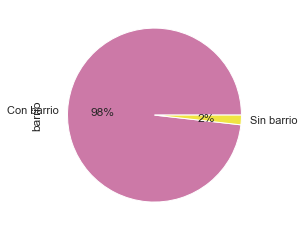

In [269]:
df['barrio'].notnull().apply(lambda x: 'Con barrio' if x else 'Sin barrio').value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['#cc79a7', '#f0e442'])

Se trata de un 2% del dataset, un valor que consideramos lo suficientemente grande como para no descartarlo.

Veamos si hay grandes diferencias de poder adquisitivo entre las personas que no indicaron su barrio y las que si.

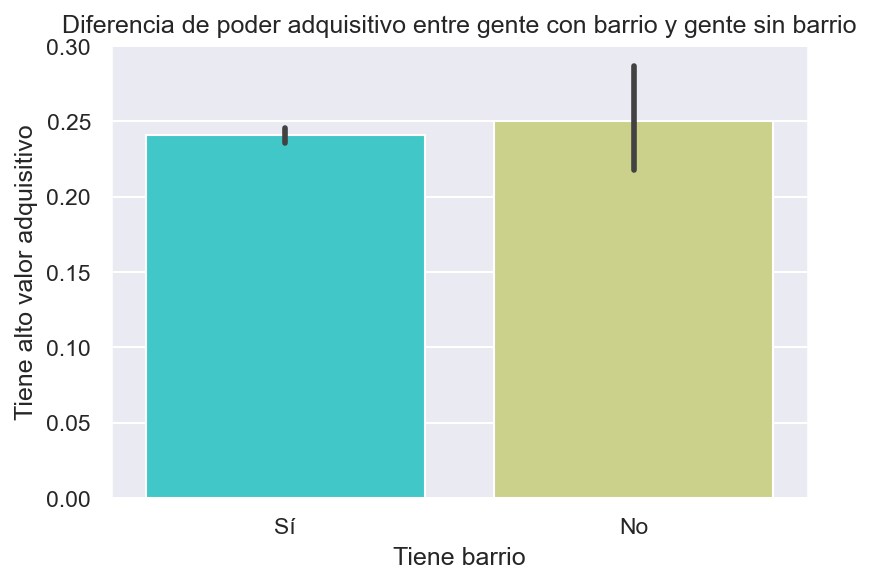

In [270]:
df_test_barrio = df[['barrio', 'tiene_alto_valor_adquisitivo']].copy()
df_test_barrio['tiene_barrio'] = df_test_barrio['barrio'].isna().apply(lambda x: 'No' if x else 'Sí')
del df_test_barrio['barrio']

plt.figure(dpi=150)
ax = sns.barplot(data=df_test_barrio, x='tiene_barrio', y='tiene_alto_valor_adquisitivo', palette='rainbow')

plt.ylabel("Tiene alto valor adquisitivo")
plt.xlabel("Tiene barrio")
plt.title('Diferencia de poder adquisitivo entre gente con barrio y gente sin barrio')
plt.show()

Vemos que, a priori, haber informado el barrio o no haberlo hecho no tiene un impacto significativo sobre la variable objetivo. Por lo tanto, rellenaremos esos valores faltantes asignando aleatoriamente un barrio, considerando la distribución de los mismos en la muestra que estamos analizando.

In [271]:
data_set_mejorado = df.copy()
barrios = df['barrio'].dropna()
cantidad = df['barrio'].isna().value_counts()[True]
muestra = barrios.sample(cantidad)
it = iter(muestra)
data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

De forma similar, analizaremos la variable `categoria_de_trabajo`.

<AxesSubplot:ylabel='categoria_de_trabajo'>

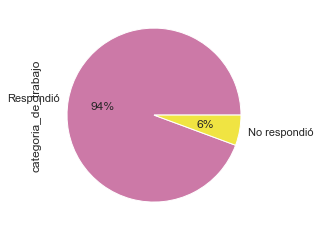

In [272]:
df['categoria_de_trabajo'].notnull().apply(lambda x: 'Respondió' if x else 'No respondió').value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['#cc79a7', '#f0e442']
)

Nuevamente estamos frente a un caso donde no podemos despreciar aquellas muestras que no informen su categoría de trabajo.

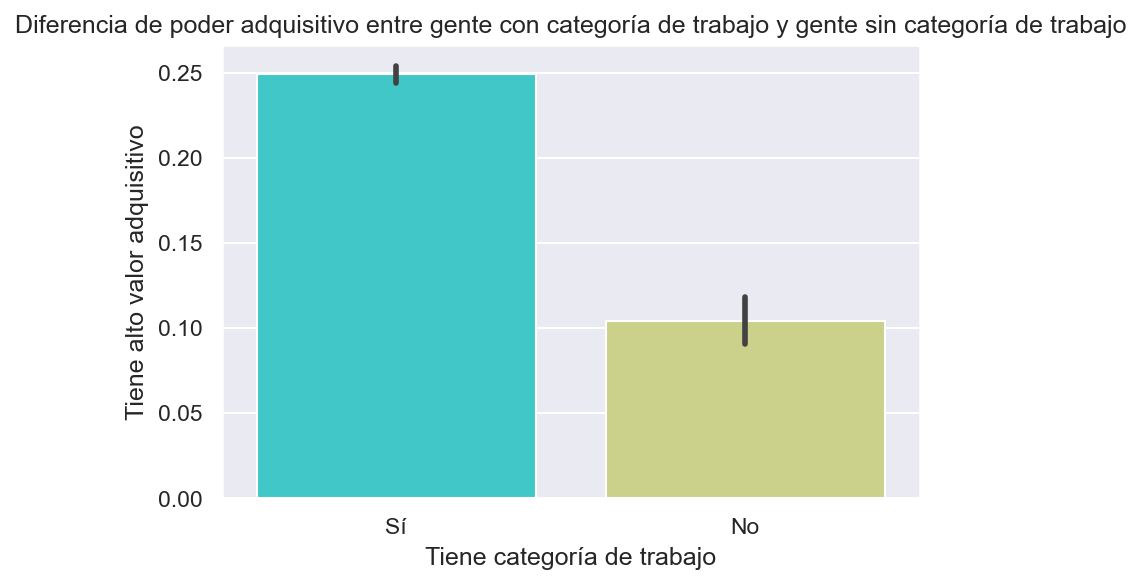

In [273]:
df_test_categoria = df[['categoria_de_trabajo', 'tiene_alto_valor_adquisitivo']].copy()
df_test_categoria['tiene_categoria'] = df_test_categoria['categoria_de_trabajo'].isna().apply(lambda x: 'No' if x else 'Sí')
del df_test_categoria['categoria_de_trabajo']

plt.figure(dpi=150)
ax = sns.barplot(data=df_test_categoria, x='tiene_categoria', y='tiene_alto_valor_adquisitivo', palette='rainbow')

plt.ylabel("Tiene alto valor adquisitivo")
plt.xlabel("Tiene categoría de trabajo")
plt.title('Diferencia de poder adquisitivo entre gente con categoría de trabajo y gente sin categoría de trabajo')
plt.show()

Aquí ya se puede ver información interesante: la gente que no responde su categoría de trabajo, en general tiene menor valor adquisitivo.

Veamos ahora la relación entre valores nulos en `trabajo` y valores nulos en `categoría_de_trabajo`.

In [274]:
df[['categoria_de_trabajo', 'trabajo']].isna().apply(lambda column: column.value_counts()[True])

categoria_de_trabajo    1836
trabajo                 1843
dtype: int64

Hay una diferencia de 7 entradas, que serán las siguientes:

In [275]:
df[df['categoria_de_trabajo'].notnull() & df['trabajo'].isna()]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
5361,10,Palermo,sin_trabajo,18,1_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,NaN
10845,8,Palermo,sin_trabajo,23,7-8_grado,divorciado,0,hombre,35,cristianismo,sin_familia,0,NaN
14772,10,Palermo,sin_trabajo,17,1_anio,sin_matrimonio,0,hombre,30,cristianismo,con_hijos,0,NaN
20337,11,Palermo,sin_trabajo,18,2_anio,sin_matrimonio,0,mujer,10,cristianismo,con_hijos,0,NaN
23232,14,Palermo,sin_trabajo,20,5_anio,sin_matrimonio,0,hombre,40,judaismo,con_hijos,0,NaN
32304,13,Palermo,sin_trabajo,30,4_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,NaN
32314,14,Palermo,sin_trabajo,18,5_anio,sin_matrimonio,0,hombre,4,cristianismo,con_hijos,0,NaN


Esto quiere decir que tener un valor NA en `categoria_de_trabajo` se corresponde con tener un valor NA  en `trabajo`, y si hay un NA en trabajo, salvo por estos últimos 7 casos, habrá un NA en `categoria_de_trabajo`.

En base a esto, vamos a crear una nueva categoría llamada "sin_categoria", para todas aquellas personas que tengan valor nulo en `categoria_de_trabajo`, y otra llamada "no_responde" para quienes tengan valor nulo en `trabajo`.

In [276]:
data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

In [277]:
data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

In [278]:
data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

A continuación estudiaremos si `educacion_alcanzada` tiene una relación fuerte con la columna `anios_estudiados`

In [279]:
df[['anios_estudiados', 'educacion_alcanzada']].groupby('educacion_alcanzada').aggregate(set)

,anios_estudiados
educacion_alcanzada,
1-4_grado,{4}
1_anio,{10}
2_anio,{11}
3_anio,{12}
4_anio,{13}
5-6_grado,{6}
5_anio,{14}
7-8_grado,{8}
9_grado,{9}


Como esperábamos, la columna `educacion_alcanzada` posee la misma información que `anios_estudiados`.

Una interpretacion de esto es que la gente que esta cargada en este set de datos nunca repitió un año escolar ni se atrasó en la carrera universitaria.

Proponemos eliminar la columna `educacion_alcanzada`, ya que es una variable categórica (más difícil de manipular) con un orden impuesto directamente por la columna `anios_estudiados`.

In [280]:
del data_set_mejorado['educacion_alcanzada']

Para finalizar, notemos que en la columna `rol_familiar_registrado` las personas solteras están identificadas con el valor "soltero_a", y no hay una distinción por género de la persona. Por el contrario, las personas casadas pueden tener valor "casado" o "casada" según su género. Dado que tenemos la posibilidad de conocer el género de la persona gracias a la columna `genero`, podemos unificar y quedarnos con un solo valor.

In [281]:
data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)

A continuación, una función que encapsula todo el trabajo realizado sobre el dataset inicial.

In [282]:
def feature_engineering(df):
    # Missings en barrio
    data_set_mejorado = df.copy()
    barrios = df['barrio'].dropna()
    cantidad = df['barrio'].isna().value_counts()[True]
    muestra = barrios.sample(cantidad)
    it = iter(muestra)
    data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

    # Missings en categoría de trabajo
    data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

    # Missings en trabajo
    data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

    # Eliminación de categoría "sin trabajo"
    data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

    # Eliminación de el atributo eduación alcanzada
    del data_set_mejorado['educacion_alcanzada']

    # Juntamos casado y casada en una misma categoría.
    data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)
    
    return data_set_mejorado

## Análisis Exploratorio

Con lo anterior, obtenemos los datos, aplicamos la función de feature engineering y comenzamos con el análisis exploratorio para clasificar a las personas muestreadas.

In [283]:
df = get_data()
df = feature_engineering(df)

Nuestra variable objetivo será `tiene_alto_valor_adquisitivo` una variable que puede tomar valores 0 ó 1.

Veamos cómo se distribuye el valor de esta variable entre los individuos de la muestra que vamos a analizar. Por tratarse de una variable dicotómica de la que solo nos interesa conocer su distribución, podemos usar un gráfico de torta.

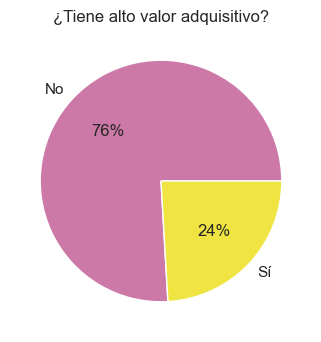

In [284]:
plt.figure(dpi=100)
df["tiene_alto_valor_adquisitivo"].apply(lambda x: 'Sí' if x==1 else 'No').value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=['#cc79a7', '#f0e442']
)
plt.title('¿Tiene alto valor adquisitivo?')
plt.ylabel("")
plt.show()

Como podemos observar, cerca de las tres cuartas partes de las personas muestreadas tienen un bajo poder adquisitivo. 

Para continuar el análisis, vamos a ver cómo se relaciona (si es que lo hacen) cada columna del dataset con la variable objetivo

In [285]:
df.columns

Index(['anios_estudiados', 'barrio', 'categoria_de_trabajo', 'edad',
       'estado_marital', 'ganancia_perdida_declarada_bolsa_argentina',
       'genero', 'horas_trabajo_registradas', 'religion',
       'rol_familiar_registrado', 'tiene_alto_valor_adquisitivo', 'trabajo'],
      dtype='object')

### Edad

#### ¿Hay una relación entre la edad y el valor adquisitivo?
Para intentar responder esta pregunta, agruparemos a los individuos muestreados por su edad, y estudiaremos cuántas personas de cada grupo etario tienen alto o bajo poder adquisitivo.

Para facilitar el análisis y la visualización de los resultados, dichos grupos etarios serán bins de 10 años.

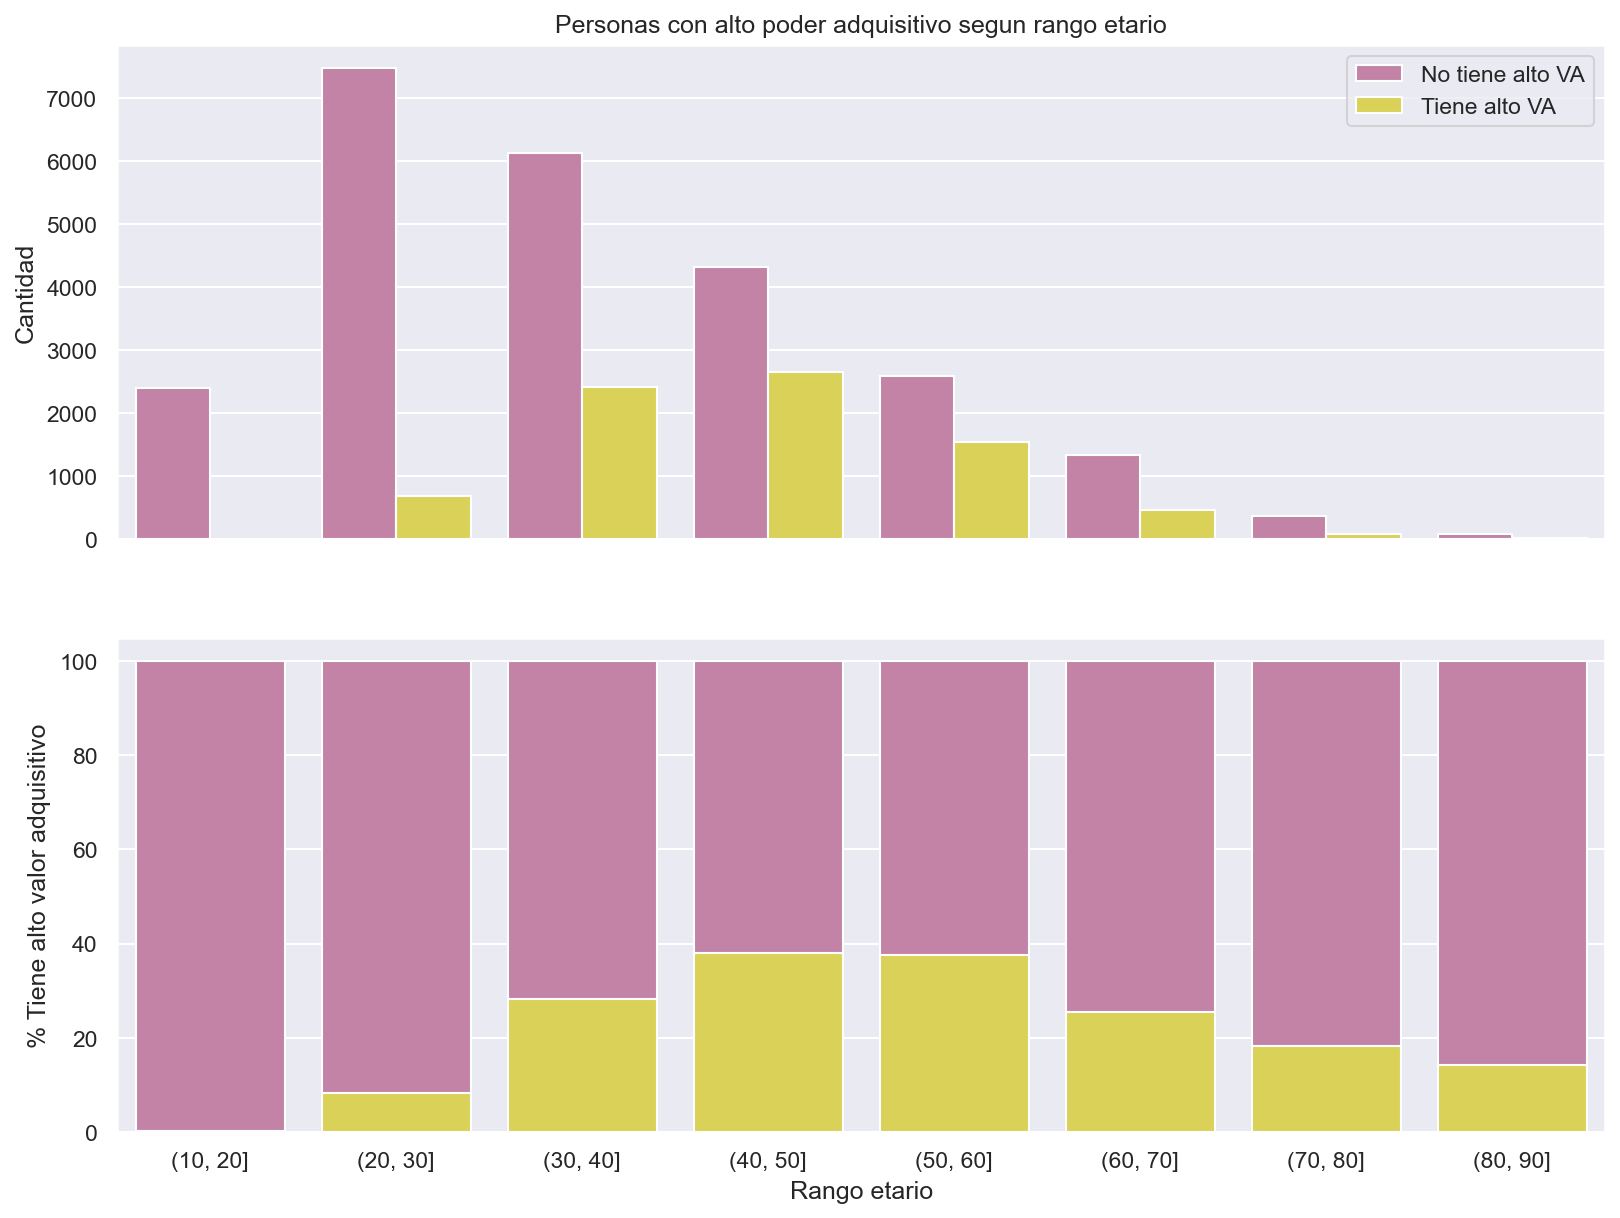

In [286]:
df_tmp = df[['edad', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['rango_etario'] = pd.cut(df_tmp.edad, range(10, int(df_tmp['edad'].max()) + 10, 10))

# Configuro el grafico, armo el countplot y setteo labels varios
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(6.4 * 2, 4.8 * 2))
sns.countplot(
    data = df_tmp,
    x = 'rango_etario',
    hue='tiene_alto_valor_adquisitivo',
    ax = ax1,
    palette = ['#cc79a7', '#f0e442']
).set(xticklabels=[])

total = df_tmp.groupby('rango_etario')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1 = df_tmp[df_tmp['tiene_alto_valor_adquisitivo']==1].groupby('rango_etario')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(df_tmp_1['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]
total['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(total['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]

bar1 = sns.barplot(x="rango_etario",  y="tiene_alto_valor_adquisitivo", data=total, color='#cc79a7', ax=ax2)
bar2 = sns.barplot(x="rango_etario", y="tiene_alto_valor_adquisitivo", data=df_tmp_1, color='#f0e442', ax=ax2)

top_bar = mpatches.Patch(color='#ff6961')
bottom_bar = mpatches.Patch(color='#77dd77')

ax1.set_title('Personas con alto poder adquisitivo segun rango etario')
ax1.set_xlabel('')
ax1.set_ylabel('Cantidad')
ax1.legend(['No tiene alto VA', 'Tiene alto VA'], loc='upper right')

ax2.set_xlabel('Rango etario')
ax2.set_ylabel('% Tiene alto valor adquisitivo')


plt.show()

Como podemos ver, es más probable encontrar personas de alto poder adquisitivo entre aquellas que están entre los 30 y 70 años de edad. Mucho menos probable es que esto ocurra para personas de entre 20 y 30 años o más de 70 años, y no ocurrirá para personas menores de 20. Cabe notar que de 70 años en adelante son muy pocas las muestras tomadas.

### Acción en la bolsa

#### ¿Hay una relación entre invertir en la bolsa y el valor adquisitivo?
Para responder esta pregunta graficaremos la cantidad de gente que accionó en bolsa y la proporción de ellos que poseen un alto poder adquisitivo. Para segmentar a los individuos de la población que estamos estudiando, consideraremos cuatro grupos: por un lado, aquellos que no declararon operaciones en la bolsa argentina, que son aquellos cuyo valor es 0 en esta columna del dataset. Por otro lado, aquellos que informaron pérdidas, identificados por un número menor a 0 en esta columna. Y, entre quienes tienen un valor positivo, consideraremos "Mucha ganancia" a los valores mayores a 7000 y "Ganancia" al resto.

In [287]:
def designar_accion(x):
    if(x > 7000):
        return "Mucha ganancia\n(>7000)"
    elif(x > 0):
        return "Ganancia"
    elif(x == 0):
        return "Nada"
    else:
        return "Perdida"

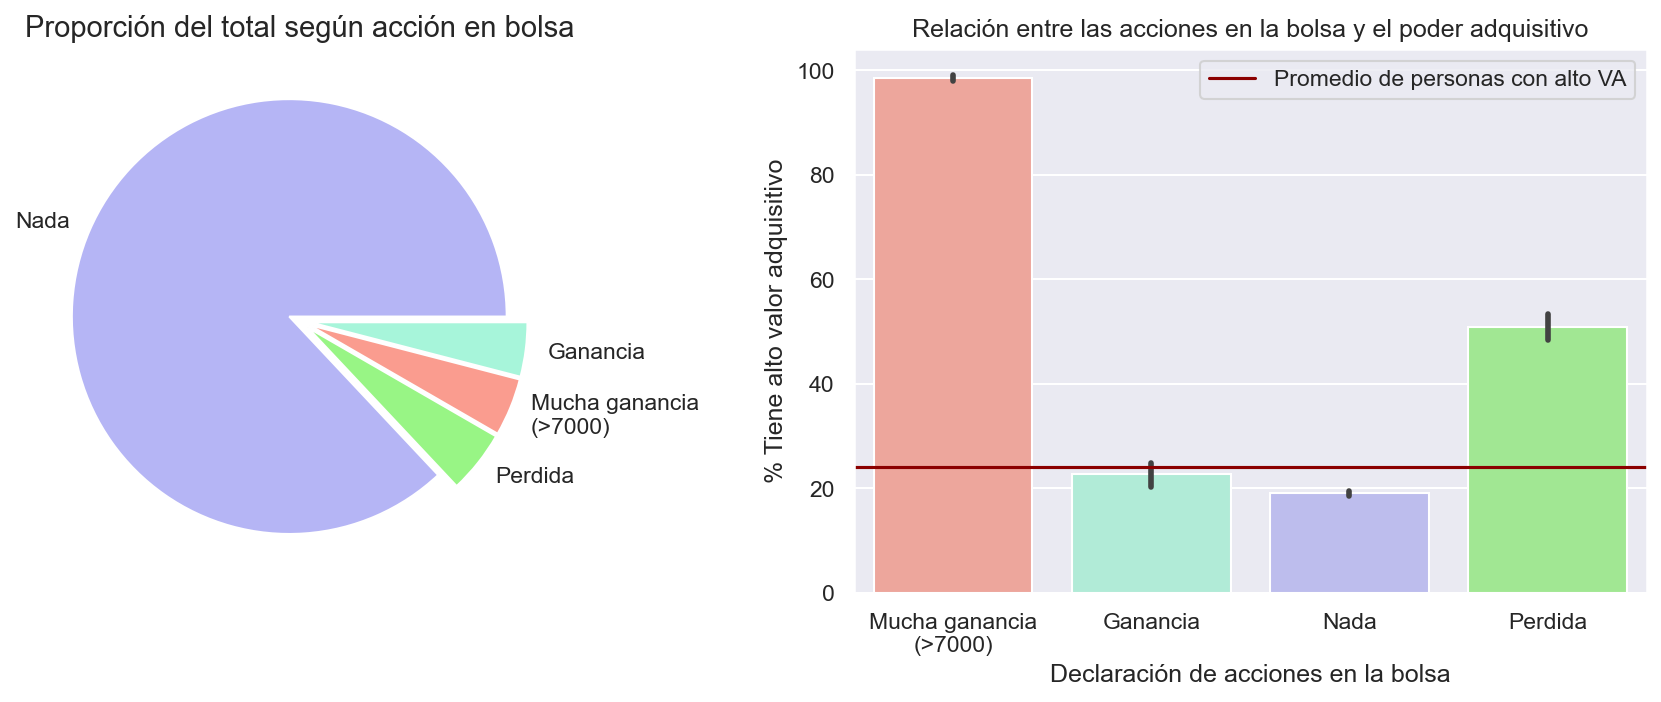

In [288]:
df_tmp = df[['ganancia_perdida_declarada_bolsa_argentina', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'].apply(designar_accion)
del df_tmp['ganancia_perdida_declarada_bolsa_argentina']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))
color_nada = '#B5B5F5'
color_perdida = '#98F585' 
color_MGanancia = '#FA9C8F'
color_ganancia = '#A7F5DA'
labels = df_tmp['bolsa'].value_counts().keys()
ax1.pie(
    x=df_tmp['bolsa'].value_counts(),
    explode=[0.05]*4,
    labels=labels,
    pctdistance=0.5,
    colors = [color_nada, color_perdida, color_MGanancia, color_ganancia]
)
ax1.set_title("Proporción del total según acción en bolsa", fontsize=14);
sns.barplot(
    data=df_tmp,
    x='bolsa',
    y='tiene_alto_valor_adquisitivo',
    ax=ax2,
    estimator=lambda x: np.mean(x)*100.0,
    order = ['Mucha ganancia\n(>7000)', 'Ganancia', 'Nada', 'Perdida'],
    palette = [color_MGanancia, color_ganancia, color_nada, color_perdida]
)
ax2.set_ylabel("% Tiene alto valor adquisitivo")
ax2.set_xlabel("Declaración de acciones en la bolsa")
ax2.set_title('Relación entre las acciones en la bolsa y el poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
ax2.legend()
plt.show()

Parece haber una relación bastante marcada con la gente que declaró un balance neto 0 en acciones de la bolsa y su poder adquisitivo, donde cerca del 80% de estas personas tienen un poder adquisitivo bajo.

Una proporción similar se puede ver entre las personas que declararon una ganancia menor a \$7000. 

También vemos que alrededor de la mitad de las personas que declararon un balance negativo en la bolsa tienen poder adquisitivo alto.

Finalmente, hay una clara relación entre la declaración de ganancias superiores a \$7000 y el poder adquisitivo de las personas que lo hicieron, donde casi la totalidad de ellas tienen un poder adquisitivo algo.

### Barrio

#### ¿Hay una relación entre el barrio y el valor adquisitivo?
Veamos la distribución de las ciudades y cómo esta afecta al poder adquisitivo. Consideraremos estadísticamente significativos aquellos barrios de los que se hayan tomado al menos 100 muestras.

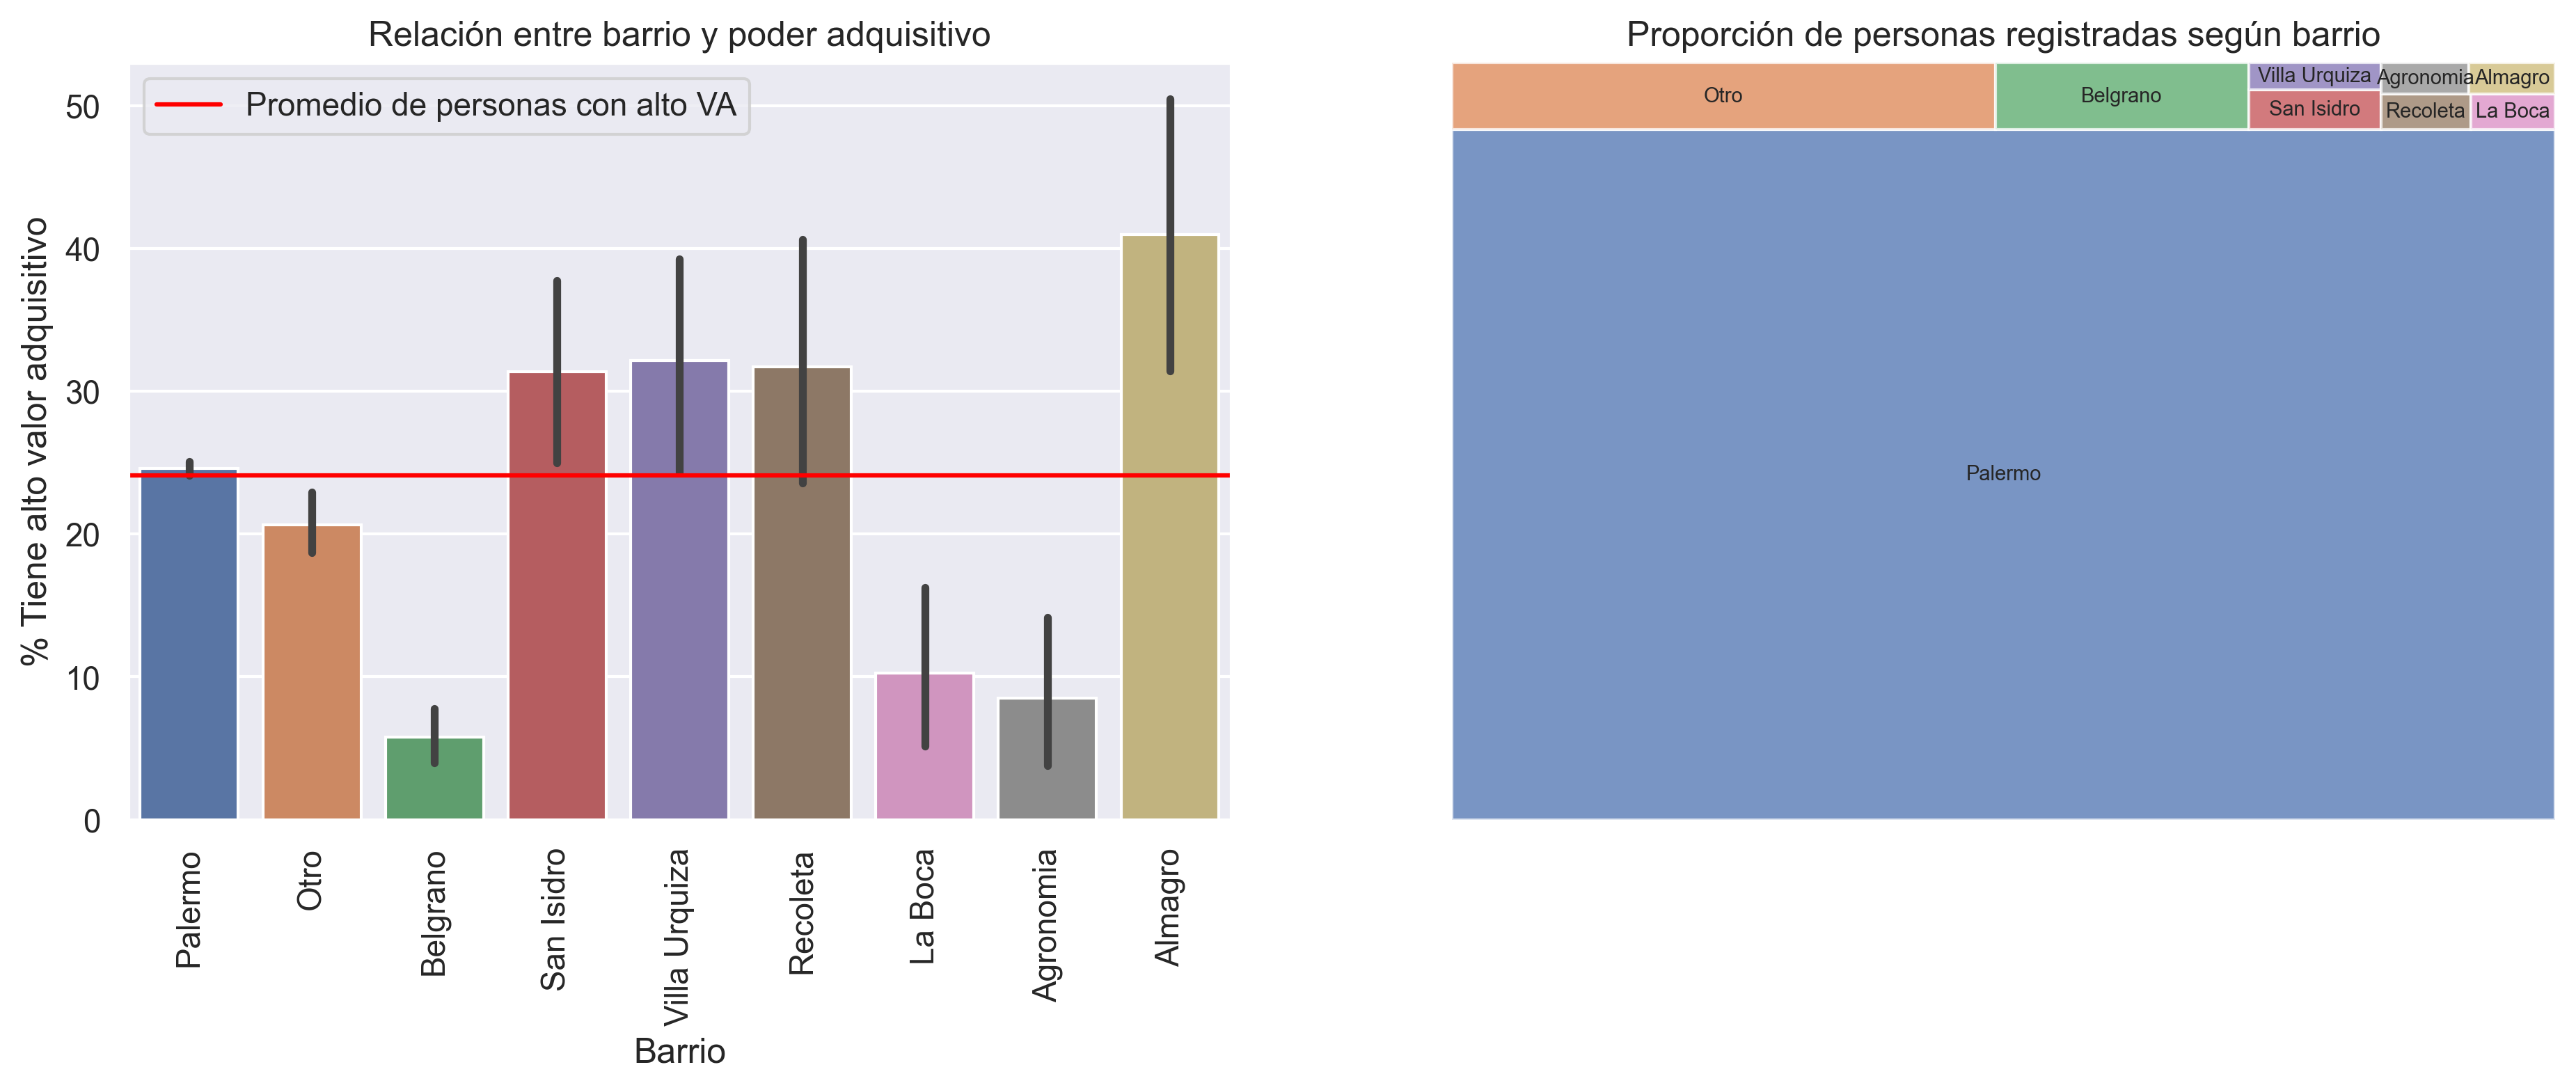

In [289]:
fig, (ax2, ax1) = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(7.5 * 2, 4.8))

cant_min = 100
tabla = df['barrio'].value_counts()
barrios_significativos = tabla[tabla > cant_min].reset_index()['index'].unique()
df_tmp = df[['barrio', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['barrio'] = df_tmp['barrio'].apply(lambda x: x if x in barrios_significativos else 'Otro')


paleta=sns.color_palette("deep")

barrios = df_tmp['barrio'].value_counts()
squarify.plot(barrios, label=barrios.keys(), alpha=0.75,color=paleta,  text_kwargs={'fontsize':7}, norm_x=1, norm_y=3, ax=ax1)
ax1.axis('off')

orden = df_tmp.groupby(['barrio'])['tiene_alto_valor_adquisitivo'].aggregate(lambda x : len(x)).reset_index().sort_values('tiene_alto_valor_adquisitivo', ascending = False)
sns.barplot(
    data=df_tmp,
    palette=paleta,
    x='barrio',
    y='tiene_alto_valor_adquisitivo',
    order=orden['barrio'],
    ax=ax2,
    estimator=lambda x: np.mean(x)*100.0
)

ax1.set_title("Proporción de personas registradas según barrio")
ax1.set_xlabel("Significancia mínima: 100 muestras")

ax2.set_ylabel("% Tiene alto valor adquisitivo")
ax2.set_xlabel("Barrio")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Relación entre barrio y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axhline(prom, color="red", label="Promedio de personas con alto VA")
ax2.legend()

plt.show()

Aquí vemos que no hay una tendencia clara que nos permita segmentar a las personas según el barrio en el que viven y a partir de eso inferir si su poder adquisitivo es alto o bajo. Además, vemos que una enorme cantidad de las muestras que estamos analizando provienen del barrio de Palermo, lo que introduciría un sesgo muy fuerte si tomáramos decisiones teniendo en cuenta esta columna. Podríamos, por ejemplo, decir que las personas que viven en Belgrano y en Agronomía tienen una alta probabilidad de tener bajo poder adquisitivo, pero eso nos llevaría al overfitting en nuestro modelo.

### Años estudiados

#### ¿Hay una relación entre la cantidad de años estudiados y el valor adquisitivo?
Veamos si encontramos una relación entre estas dos variables.

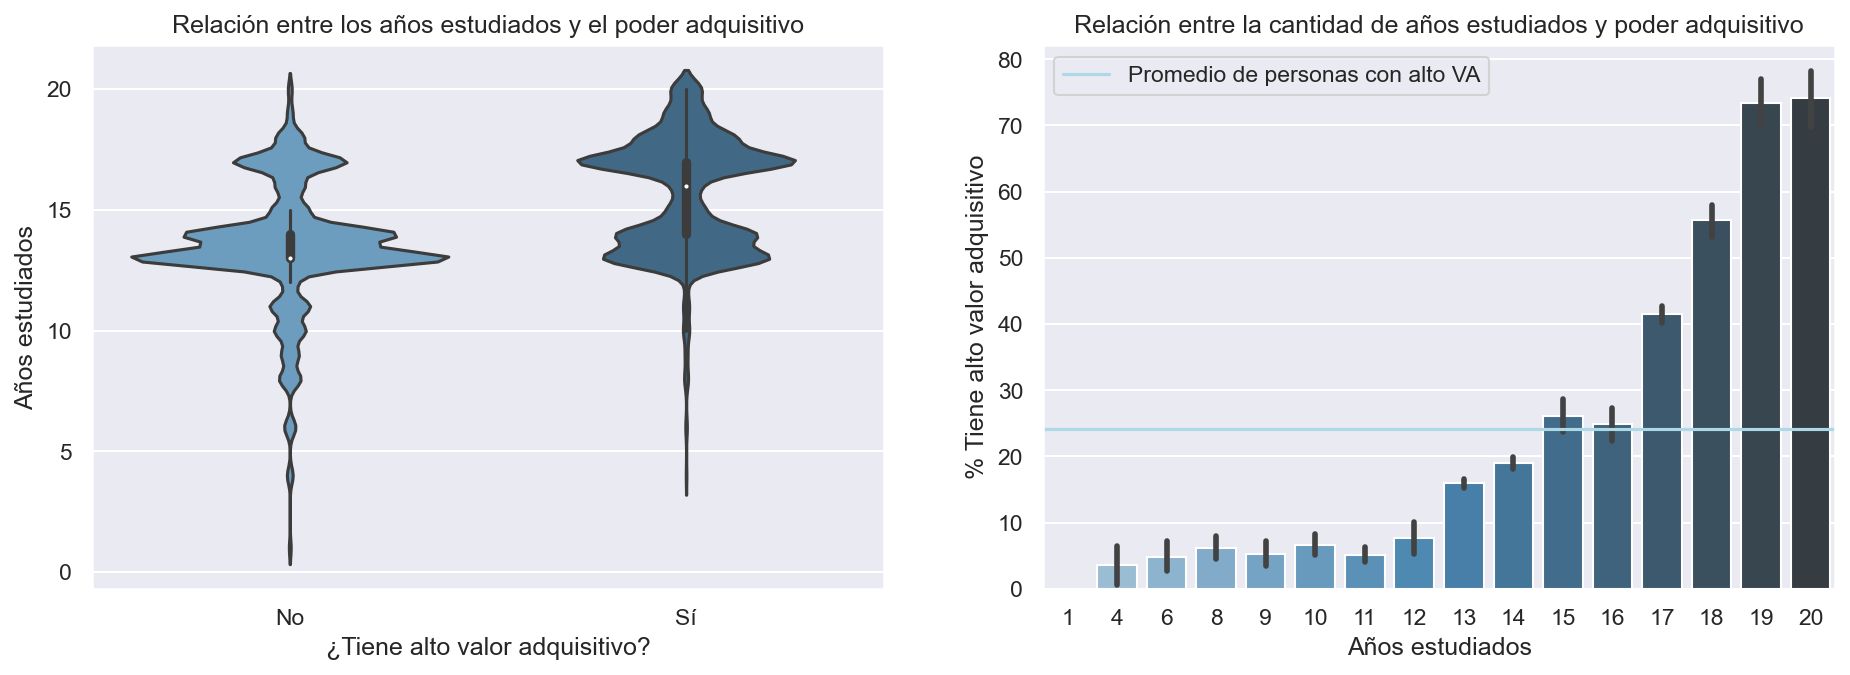

In [290]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

df_tmp = df[['anios_estudiados', 'tiene_alto_valor_adquisitivo']].copy()

ax1.set_title("Relación entre los años estudiados y el poder adquisitivo")
sns.violinplot(
    data=df_tmp,
    x='tiene_alto_valor_adquisitivo',
    y='anios_estudiados',
    ax=ax1,
    palette="Blues_d"
)
ax1.tick_params(which='both', width=2)
ax1.set_ylabel("Años estudiados")
ax1.set_xlabel("¿Tiene alto valor adquisitivo?")
ax1.set_xticklabels(labels=["No", "Sí"])

sns.barplot(
    data=df_tmp,
    palette="Blues_d",
    x='anios_estudiados',
    y='tiene_alto_valor_adquisitivo',
    ax=ax2,
    estimator = lambda x: np.mean(x)*100.0
)

ax2.set_ylabel("% Tiene alto valor adquisitivo")
ax2.set_xlabel("Años estudiados")
ax2.set_title('Relación entre la cantidad de años estudiados y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axhline(prom, color="lightblue", label="Promedio de personas con alto VA")
ax2.legend()

plt.show()

Podemos ver una relación muy marcada entre estas dos variables, donde quienes tienen 12 años de estudio o menos se encuentran entre la población de menor poder adquisitivo, y quienes superan los 18 años de estudio tienden a tener un poder adquisitivo alto. El violin plot de la izquierda, a su vez, nos ayuda a ver que los dos grupos antes mencionados cuentan con pocos individuos presentes en la muestra, mientras que el conjunto que tiene entre 13 y 17 años de estudios concentra a la mayor parte de la población muestreada. 

### Horas trabajadas

#### ¿Hay una relación entre la cantidad de horas trabajadas y el valor adquisitivo?


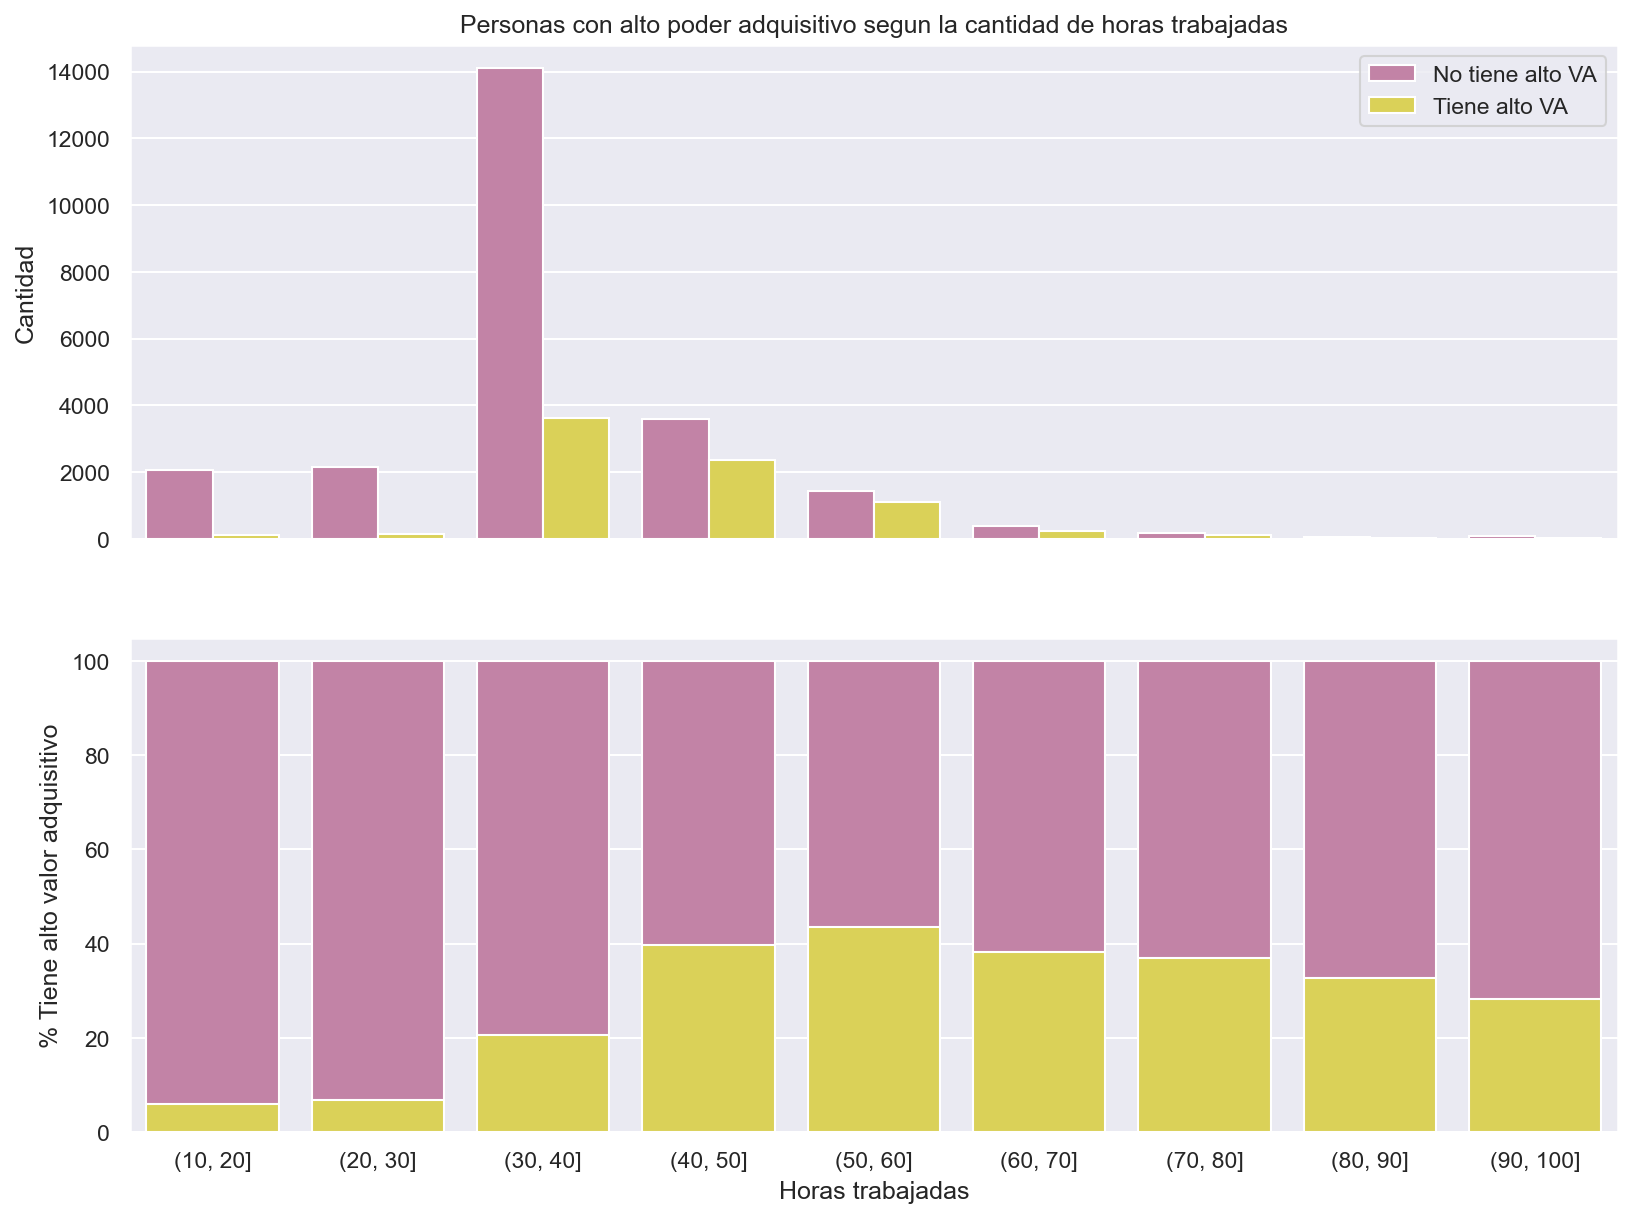

In [291]:
df_tmp = df[['horas_trabajo_registradas', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['rango_horas_trabajadas'] = pd.cut(df_tmp.horas_trabajo_registradas, range(10, int(df_tmp['horas_trabajo_registradas'].max()) + 10, 10))

# Configuro el grafico, armo el countplot y setteo labels varios
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(6.4 * 2, 4.8 * 2))
sns.countplot(
    data = df_tmp,
    x = 'rango_horas_trabajadas',
    hue='tiene_alto_valor_adquisitivo',
    ax = ax1,
    palette = ['#cc79a7', '#f0e442']
).set(xticklabels=[])

total = df_tmp.groupby('rango_horas_trabajadas')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1 = df_tmp[df_tmp['tiene_alto_valor_adquisitivo']==1].groupby('rango_horas_trabajadas')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(df_tmp_1['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]
total['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(total['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]

bar1 = sns.barplot(x="rango_horas_trabajadas",  y="tiene_alto_valor_adquisitivo", data=total, color='#cc79a7', ax=ax2)
bar2 = sns.barplot(x="rango_horas_trabajadas", y="tiene_alto_valor_adquisitivo", data=df_tmp_1, color='#f0e442', ax=ax2)

top_bar = mpatches.Patch(color='#ff6961')
bottom_bar = mpatches.Patch(color='#77dd77')

ax1.set_title('Personas con alto poder adquisitivo segun la cantidad de horas trabajadas')
ax1.set_xlabel('')
ax1.set_ylabel('Cantidad')
ax1.legend(['No tiene alto VA', 'Tiene alto VA'], loc='upper right')

ax2.set_xlabel('Horas trabajadas')
ax2.set_ylabel('% Tiene alto valor adquisitivo')


plt.show()

Vemos que en los casos en que las horas trabajadas son menores o iguales a 30 casi todas las personas muestreadas tienen un poder adquisitivo bajo. Los individuos con poder adquisitivo alto empiezan a aparecer en su mayoría a partir de las 30 horas trabajadas, y para 40 horas en adelante empiezan a ocupar un porcentaje importante de la muestra. Por ejemplo, para quienes trabajan entre 50 y 60 horas, la relación es casi 50/50.

### ¿Influye el rol familiar registrado sobre el poder adquisitivo? ¿Las personas con hijos tienen menos poder adquisitivo?

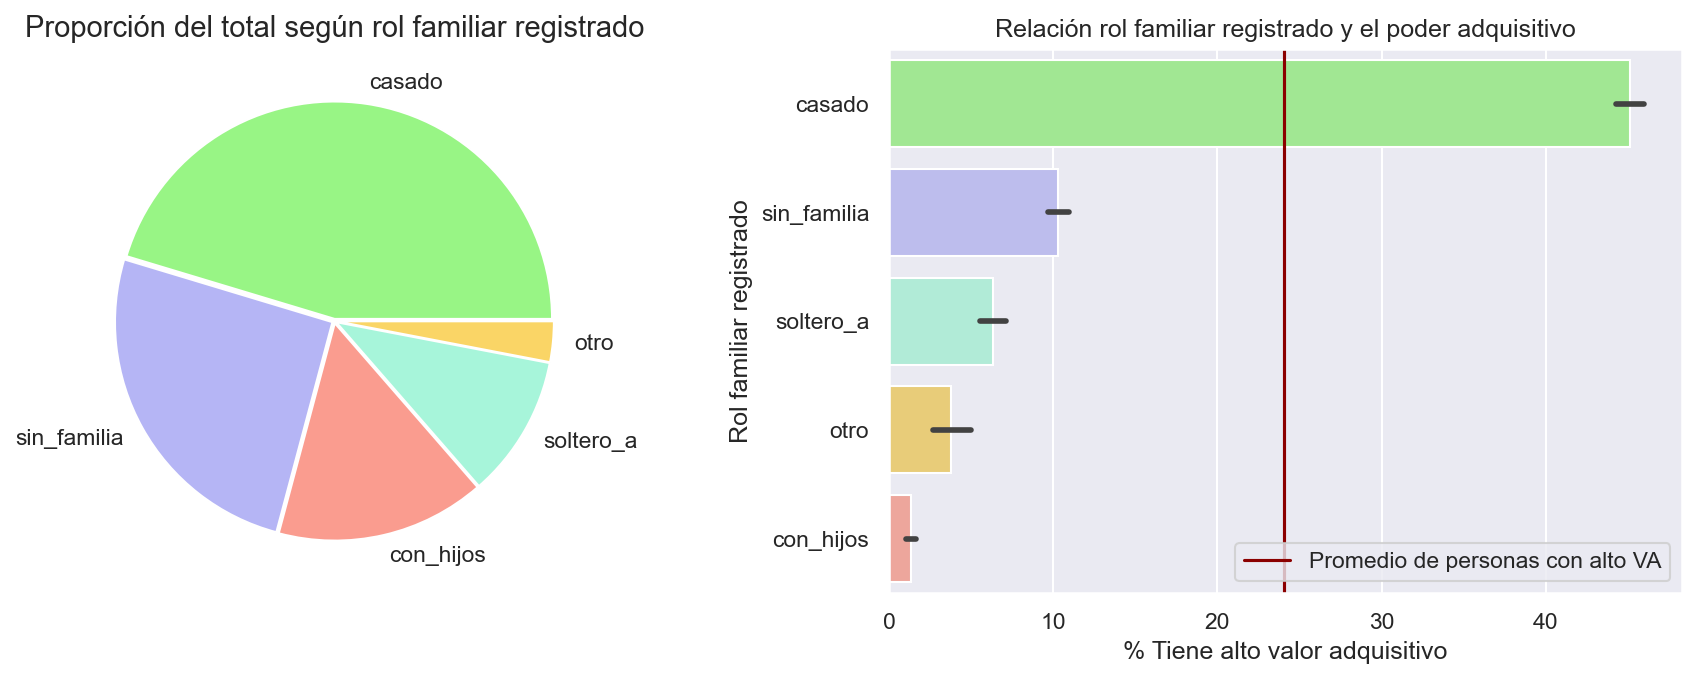

In [292]:
df_tmp = df[['rol_familiar_registrado', 'tiene_alto_valor_adquisitivo']].copy()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

color_sinFam = '#B5B5F5'
color_casado = '#98F585' 
color_conHijos = '#FA9C8F'
color_soltero = '#A7F5DA'
color_otro = '#FAD566'

labels = df_tmp['rol_familiar_registrado'].value_counts().keys()
ax1.pie(
    x=df_tmp['rol_familiar_registrado'].value_counts(),
    explode=[0.01]*len(df_tmp['rol_familiar_registrado'].value_counts()),
    labels=labels,
    pctdistance=0.5,
    colors = [color_casado, color_sinFam, color_conHijos, color_soltero, color_otro]
)

ax1.set_title("Proporción del total según rol familiar registrado", fontsize=14);
sns.barplot(
    data=df_tmp,
    y='rol_familiar_registrado',
    x='tiene_alto_valor_adquisitivo',
    ax=ax2,
    estimator=lambda x: np.mean(x)*100.0,
    order = ['casado', 'sin_familia', 'soltero_a', 'otro','con_hijos'],
    palette = [color_casado, color_sinFam, color_soltero, color_otro, color_conHijos]
)

ax2.set_ylabel("Rol familiar registrado")
ax2.set_xlabel("% Tiene alto valor adquisitivo")
ax2.set_title('Relación rol familiar registrado y el poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axvline(prom, color="darkred", label="Promedio de personas con alto VA")
ax2.legend()
plt.show()

Si bien no vemos una categoría que se incline a tener un alto poder adquisitivo por sobre el resto, vemos que en general las personas sin familia, solteros/as, con hijos y otros se inclinan notablemente a tener un poder adquisitivo bajo.

#### ¿La religión afecta al poder adquisitivo? ¿El género? ¿Afectan en conjunto?

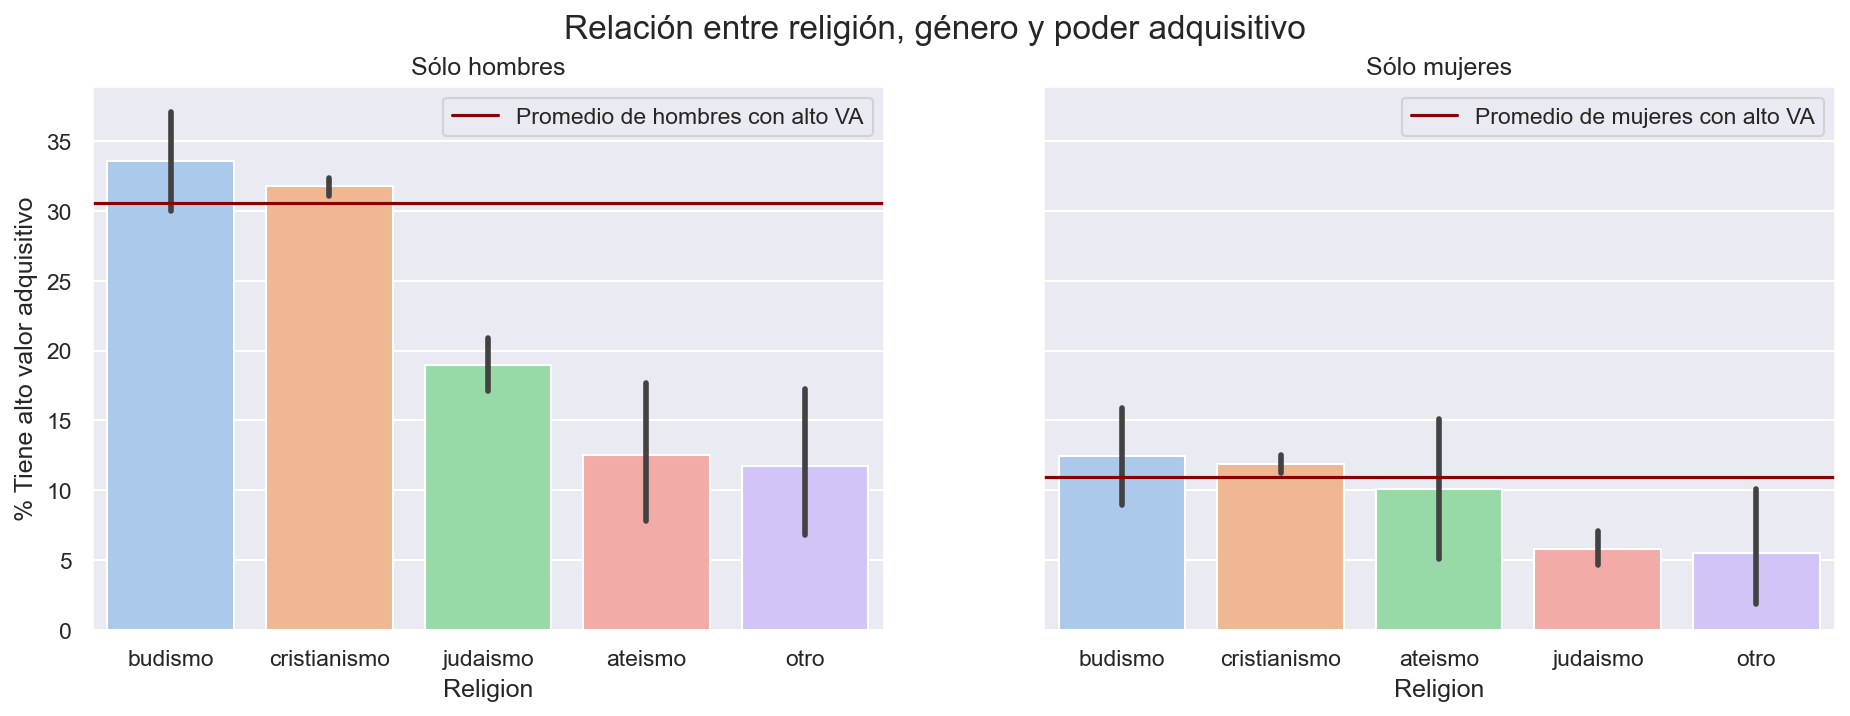

In [293]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5*2, 4.8), sharey=True)
df_tmp_h = df[df['genero'] == 'hombre']
orden = df_tmp_h.groupby(['religion'])['tiene_alto_valor_adquisitivo'].aggregate(lambda x : np.mean(x)).reset_index().sort_values('tiene_alto_valor_adquisitivo', ascending = False)
sns.barplot(
    data=df_tmp_h,
    palette="pastel",
    x='religion',
    y='tiene_alto_valor_adquisitivo',
    ax=ax1,
    order=orden['religion'],
    estimator=lambda x: np.mean(x)*100.0
)
prom = df_tmp_h['tiene_alto_valor_adquisitivo'].mean()*100.0
ax1.set_ylabel("% Tiene alto valor adquisitivo")
ax1.set_xlabel("Religion")
ax1.set_title('Sólo hombres')
ax1.axhline(prom, color="darkred", label="Promedio de hombres con alto VA")
ax1.legend()
df_tmp_m = df[df['genero'] == 'mujer']
orden = df_tmp_m.groupby(['religion'])['tiene_alto_valor_adquisitivo'].aggregate(lambda x : np.mean(x)).reset_index().sort_values('tiene_alto_valor_adquisitivo', ascending = False)
sns.barplot(
    data=df_tmp_m,
    palette="pastel",
    x='religion',
    y='tiene_alto_valor_adquisitivo',
    ax=ax2,
    order=orden['religion'],
    estimator=lambda x: np.mean(x)*100.0
)
prom = df_tmp_m['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.set_ylabel("")
ax2.set_xlabel("Religion")
ax2.set_title('Sólo mujeres')
ax2.axhline(prom, color="darkred", label="Promedio de mujeres con alto VA")
ax2.legend()
fig.suptitle('Relación entre religión, género y poder adquisitivo', fontsize=16)
plt.show()

Nuevamente, no encontramos elementos en esta variable que nos lleven a clasificar a los miembros de alguna religión en particular como personas de alto poder adquisitivo, pero sí podemos observar muy pocas mujeres que profesen el judaísmo u otras religiones y tengan alto poder adquisitivo.

### ¿El rol familiar registrado y el estado marital tienen la misma influencia sobre el poder adquisitivo?
Esto es, ¿obtener información de una de esas variables da información sobre la otra? Veámoslo en un heatmap.

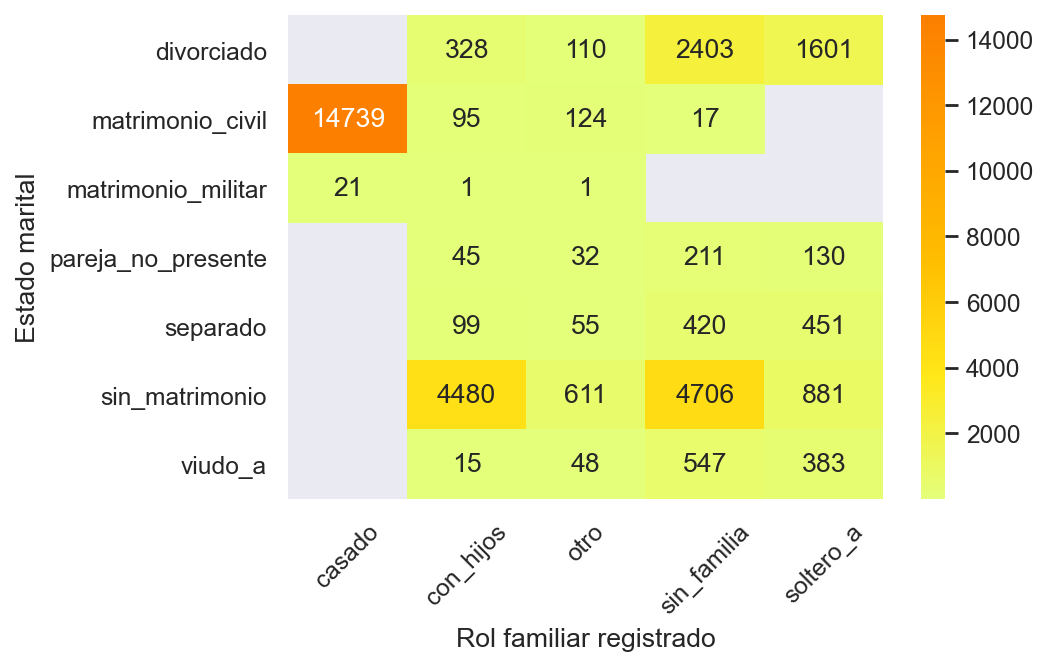

In [294]:
plt.figure(dpi = 160)
df_tmp = df[['estado_marital','rol_familiar_registrado', 'tiene_alto_valor_adquisitivo']].copy()
cooccurrence_g = pd.pivot_table(
    df_tmp,
    'tiene_alto_valor_adquisitivo',
    'estado_marital',
    'rol_familiar_registrado',
    'count'
)
sns.heatmap(cooccurrence_g, cmap='Wistia', annot=True, fmt=".5g")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.ylabel("Estado marital")
plt.xlabel("Rol familiar registrado")
plt.show()

De las celdas con datos faltantes y las cantidades observadas podemos deducir que, efectivamente, en términos generales la información obtenida de ambas variables es equivalente.

### Trabajo y categoría de trabajo

Veamos qué resulta de intersecar las categorías de las variables `trabajo` y `categoria_de_trabajo` , visualizándolas 

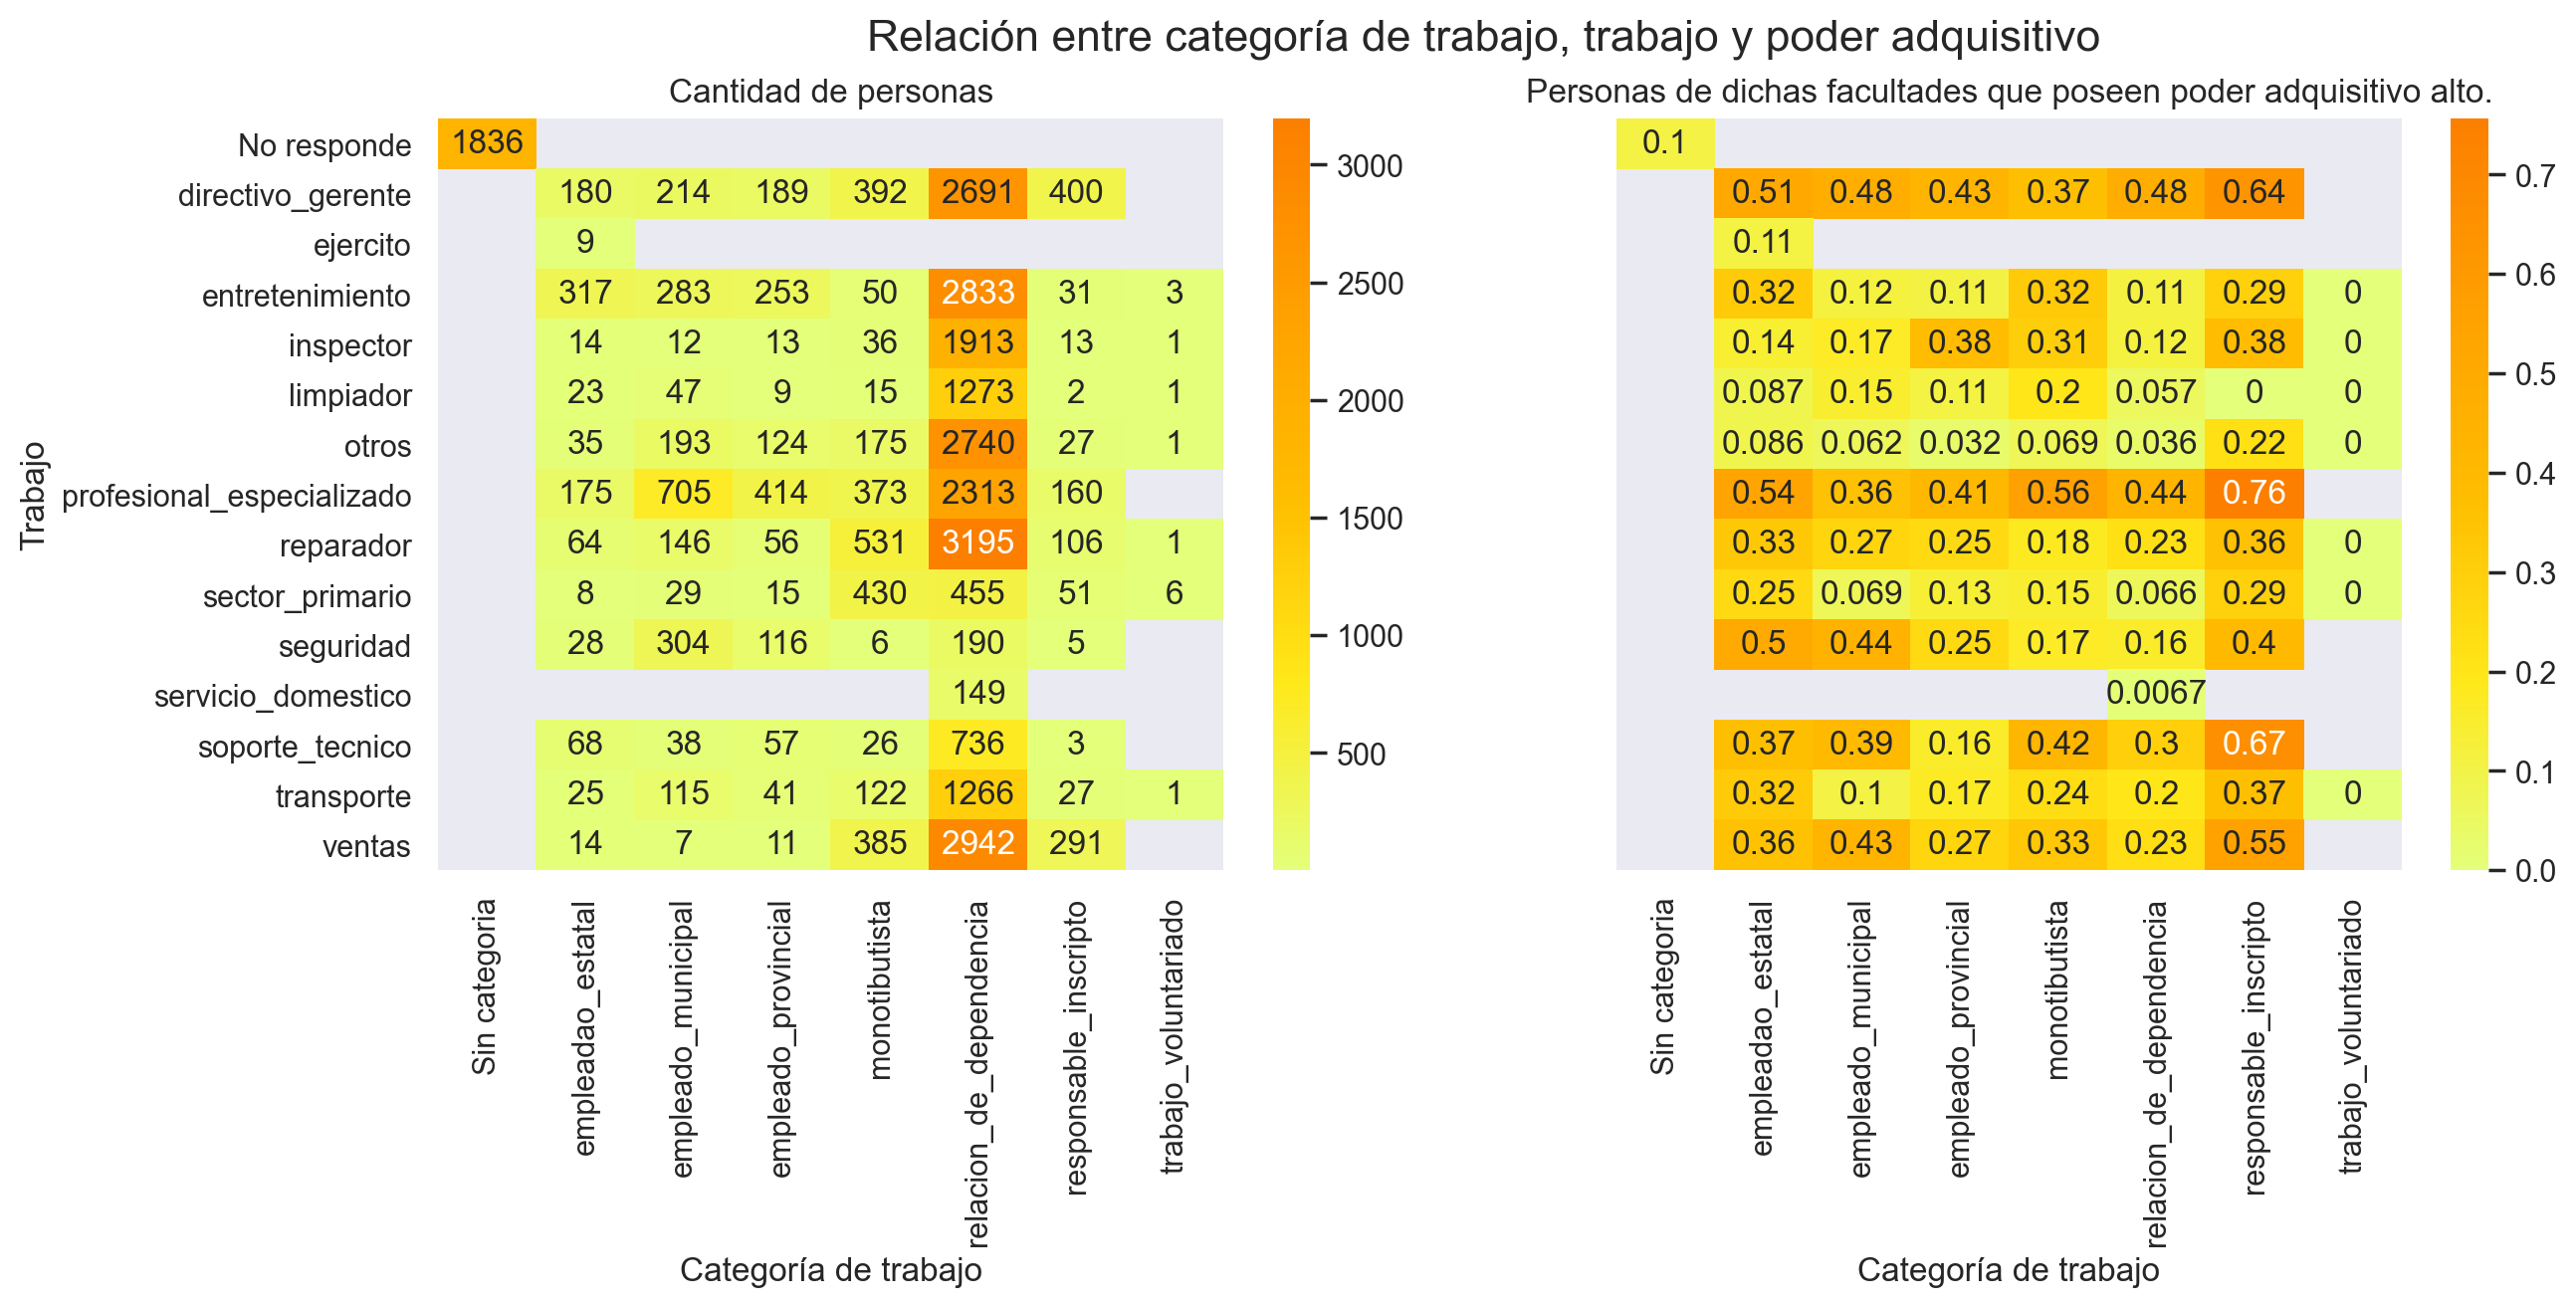

In [295]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(7*2, 5))
df_tmp = df[['trabajo','categoria_de_trabajo', 'tiene_alto_valor_adquisitivo']].copy()
cooccurrence_count = pd.pivot_table(
    df_tmp,
    'tiene_alto_valor_adquisitivo',
    'trabajo',
    'categoria_de_trabajo',
    'count'
)
cooccurrence_mean = pd.pivot_table(
    df_tmp,
    'tiene_alto_valor_adquisitivo',
    'trabajo',
    'categoria_de_trabajo',
    'mean'
)
sns.heatmap(cooccurrence_count, cmap='Wistia', annot=True, fmt=".5g", ax=ax1)
sns.heatmap(cooccurrence_mean, cmap='Wistia', annot=True, fmt=".2g", ax=ax2).set(yticklabels=[])
ax1.set_ylabel("Trabajo")
ax1.set_xlabel("Categoría de trabajo")
ax1.set_title("Cantidad de personas")
ax2.set_ylabel("")
ax2.set_xlabel("Categoría de trabajo")
ax2.set_title("Personas de dichas facultades que poseen poder adquisitivo alto.")
fig.suptitle('Relación entre categoría de trabajo, trabajo y poder adquisitivo', fontsize=16)
plt.show()

De aquí se pueden observar relaciones interesantes entre las variables y cómo estas afectan el poder adquisitivo. Sin embargo, decidimos desestimar a priori esta información pues, en caso de usarla, creemos que será muy específico sobre datos que en general no tienen suficiente significancia estadística.
Como se puede ver en el gráfico de la izquierda, la mayor parte de la gente está declarada como 'En relación de dependencia' y, como se puede ver en el gráfico de la derecha, dicha relación no nos ayuda a encontrar personas con alto poder adquisitivo, pues sus valores son de caracter fluctuante.

## Observaciones

## Baseline

##### Construyendo el Baseline
Iremos particionando el dominio en base a los resultados obtenidos en el análisis exploratorio.

La primera cualidad observada del análisis de los datos es que casi la totalidad de la gente que obtuvo una ganancia superior a 7000 en la bolsa, tiene poder adquisitivo alto.

Por lo cual, nos quedaremos para analizar sólo a aquellos que no ganaron más de 7000 en la bolsa

In [310]:
df_pipeline = df[df['ganancia_perdida_declarada_bolsa_argentina'] < 7000]

La segunda cualidad que observamos en el análisis de datos sobre el data frame original fue la edad, cuyo valor condicionaba de la siguiente forma:
* Si tenés menos de 30 años o más de 70 años, todo parece indicar que no posees un alto valor adquisitivo
* En cambio, si te encontrás en el rango intermedio, que tengas valor adquisitivo alto dependerá de otras cualidades

Veamos si esto se mantiene en nuestro data frame actual, para ello graficaremos lo mismo pero con los datos recortados

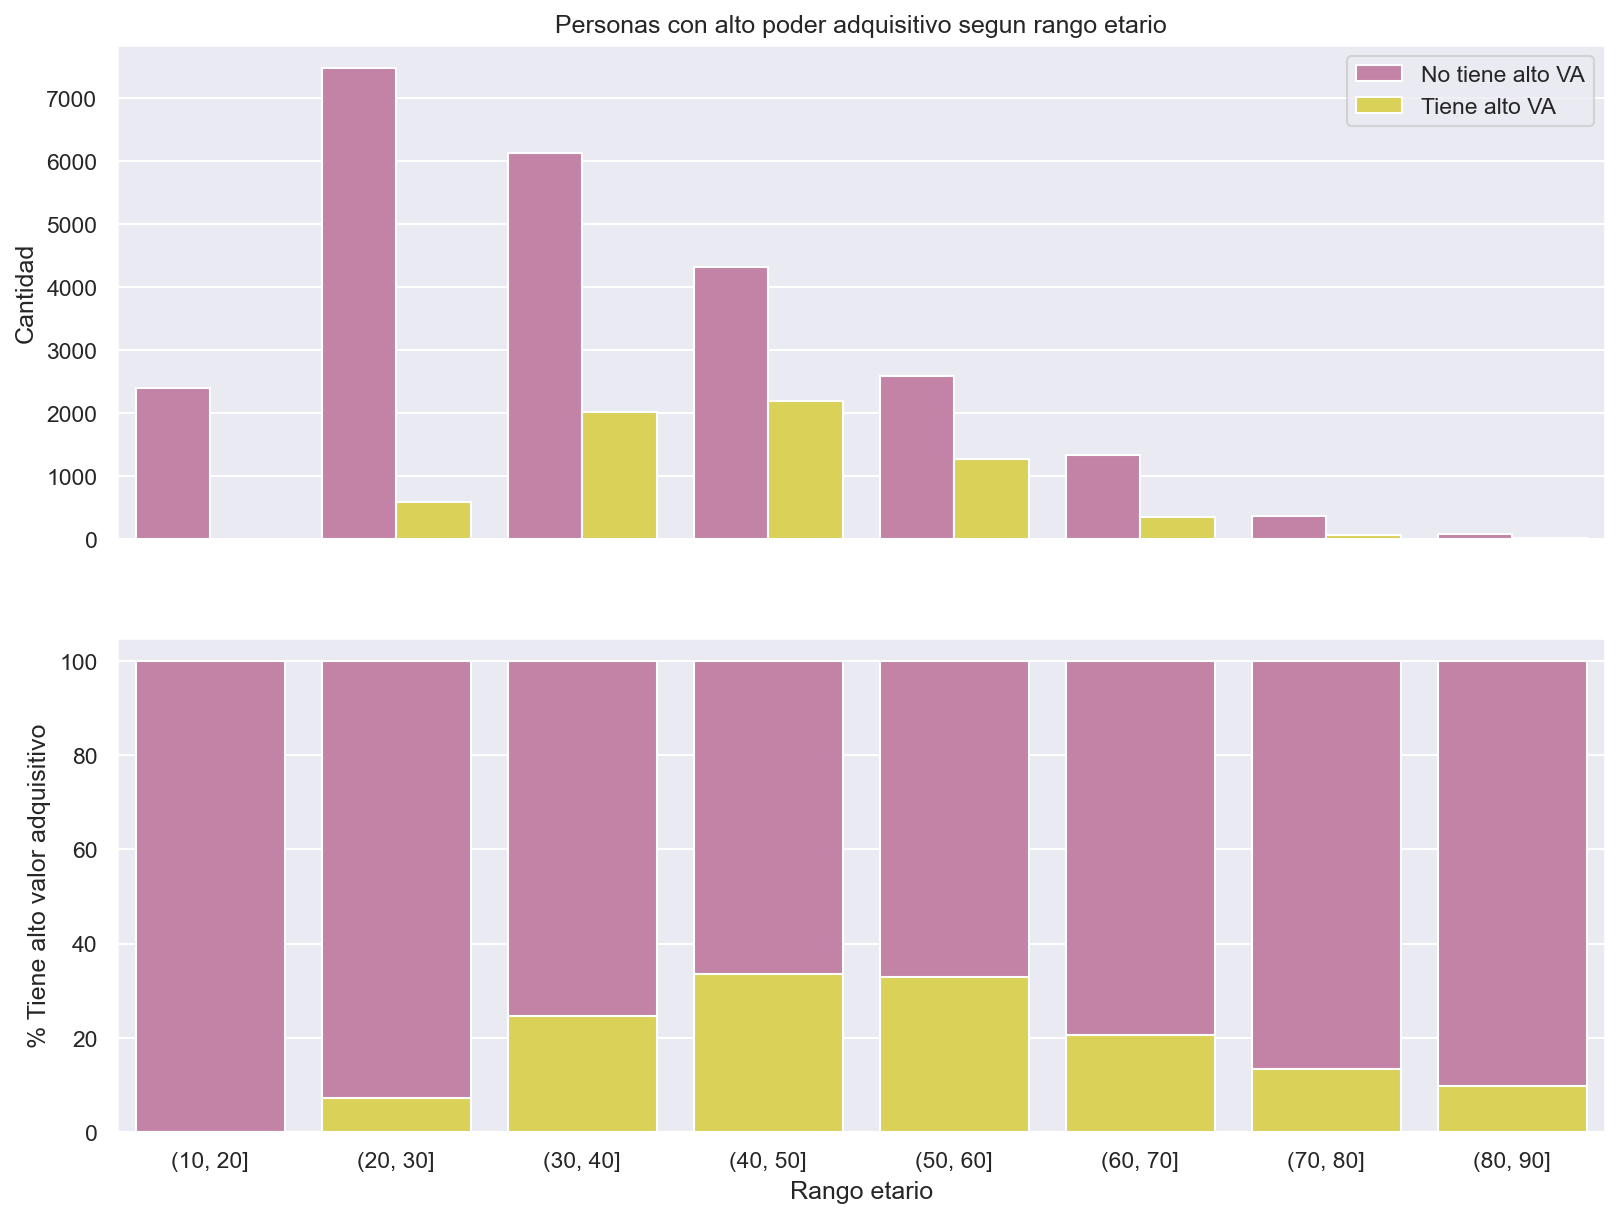

In [300]:
df_tmp = df_pipeline[['edad', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['rango_etario'] = pd.cut(df_tmp.edad, range(10, int(df_tmp['edad'].max()) + 10, 10))

# Configuro el grafico, armo el countplot y setteo labels varios
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(6.4 * 2, 4.8 * 2))
sns.countplot(
    data = df_tmp,
    x = 'rango_etario',
    hue='tiene_alto_valor_adquisitivo',
    ax = ax1,
    palette = ['#cc79a7', '#f0e442']
).set(xticklabels=[])

total = df_tmp.groupby('rango_etario')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1 = df_tmp[df_tmp['tiene_alto_valor_adquisitivo']==1].groupby('rango_etario')['tiene_alto_valor_adquisitivo'].count().reset_index()
df_tmp_1['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(df_tmp_1['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]
total['tiene_alto_valor_adquisitivo'] = [i / j * 100 for i,j in zip(total['tiene_alto_valor_adquisitivo'], total['tiene_alto_valor_adquisitivo'])]

bar1 = sns.barplot(x="rango_etario",  y="tiene_alto_valor_adquisitivo", data=total, color='#cc79a7', ax=ax2)
bar2 = sns.barplot(x="rango_etario", y="tiene_alto_valor_adquisitivo", data=df_tmp_1, color='#f0e442', ax=ax2)

top_bar = mpatches.Patch(color='#ff6961')
bottom_bar = mpatches.Patch(color='#77dd77')

ax1.set_title('Personas con alto poder adquisitivo segun rango etario')
ax1.set_xlabel('')
ax1.set_ylabel('Cantidad')
ax1.legend(['No tiene alto VA', 'Tiene alto VA'], loc='upper right')

ax2.set_xlabel('Rango etario')
ax2.set_ylabel('% Tiene alto valor adquisitivo')


plt.show()

Observamos que efectivamente se puede seguir obteniendo la misma información de dichos gráficos.


Por lo que, nos quedaremos con las personas cuyo rango etario esté entre 30 y 70 años.

In [312]:
df_pipeline = df_pipeline[df_pipeline['edad'].isin(range(31, 71))]

De la información recolectada en el análisis exploratorio pudimos observar como el estado marital influye tremendamente en la variable objetivo, siendo que tener hijos quita a la mayor parte de la población de tener un alto poder adquisitivo, asímismo también lo hacen si tenés 'otro' o 'soltero_a'.

Revisemos si estas afirmaciones siguen siendo válidas para la gente entre 30 y 70 años que no accionó con mucho éxito en la bolsa.

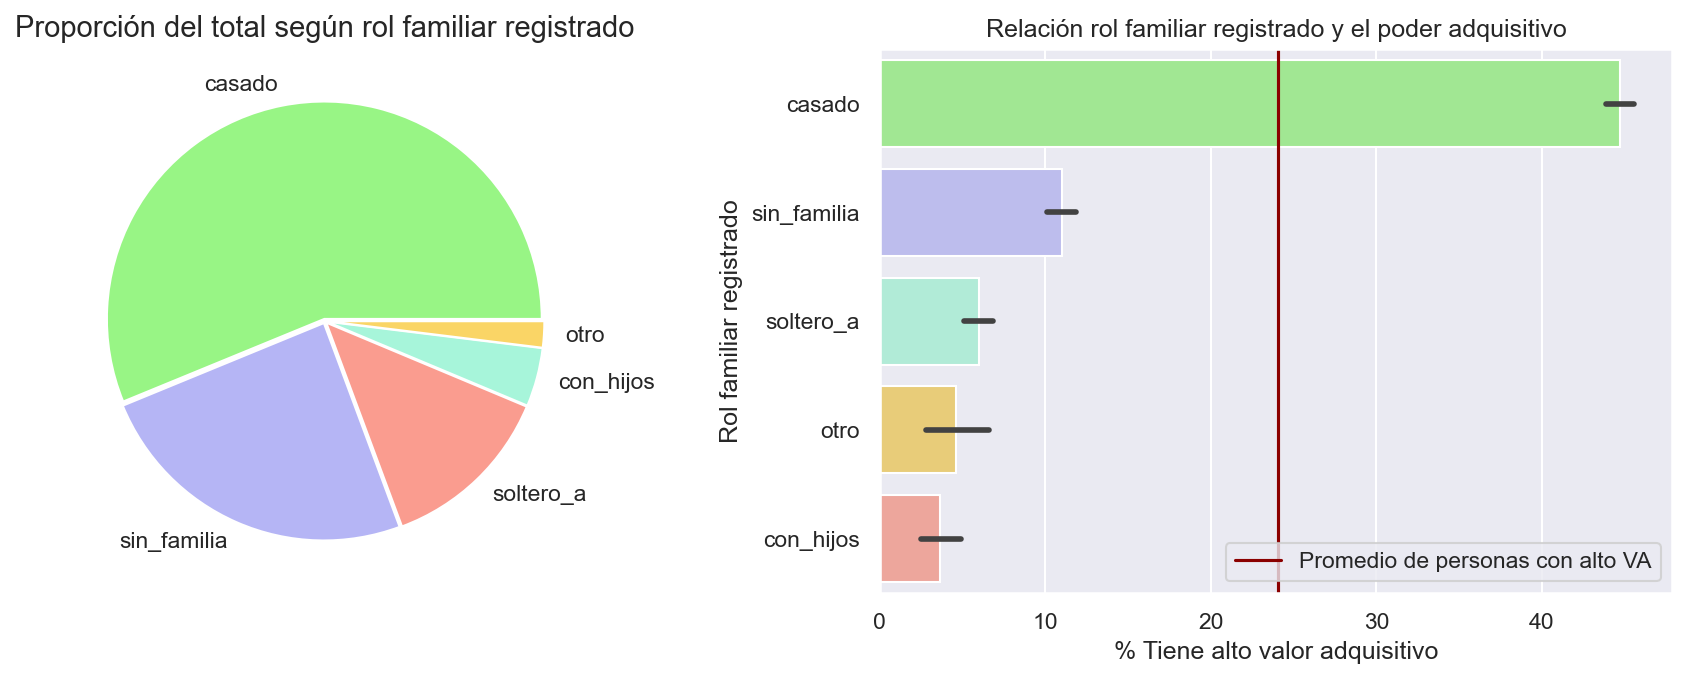

In [313]:
df_tmp = df_pipeline[['rol_familiar_registrado', 'tiene_alto_valor_adquisitivo']].copy()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

color_sinFam = '#B5B5F5'
color_casado = '#98F585' 
color_conHijos = '#FA9C8F'
color_soltero = '#A7F5DA'
color_otro = '#FAD566'

labels = df_tmp['rol_familiar_registrado'].value_counts().keys()
ax1.pie(
    x=df_tmp['rol_familiar_registrado'].value_counts(),
    explode=[0.01]*len(df_tmp['rol_familiar_registrado'].value_counts()),
    labels=labels,
    pctdistance=0.5,
    colors = [color_casado, color_sinFam, color_conHijos, color_soltero, color_otro]
)

ax1.set_title("Proporción del total según rol familiar registrado", fontsize=14);
sns.barplot(
    data=df_tmp,
    y='rol_familiar_registrado',
    x='tiene_alto_valor_adquisitivo',
    ax=ax2,
    estimator=lambda x: np.mean(x)*100.0,
    order = ['casado', 'sin_familia', 'soltero_a', 'otro','con_hijos'],
    palette = [color_casado, color_sinFam, color_soltero, color_otro, color_conHijos]
)

ax2.set_ylabel("Rol familiar registrado")
ax2.set_xlabel("% Tiene alto valor adquisitivo")
ax2.set_title('Relación rol familiar registrado y el poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axvline(prom, color="darkred", label="Promedio de personas con alto VA")
ax2.legend()
plt.show()

Por lo que se puede observar que se mantiene lo dicho anteriormente, es decir, la gente que no está casada, tiene altas chances de no tener poder adquisitivo alto.

Por lo que:

In [320]:
df_pipeline = df_pipeline[df_pipeline['rol_familiar_registrado'] == 'casado']

Veamos cómo evolucionó la variable de ganancia/perdida declarada en la bolsa.

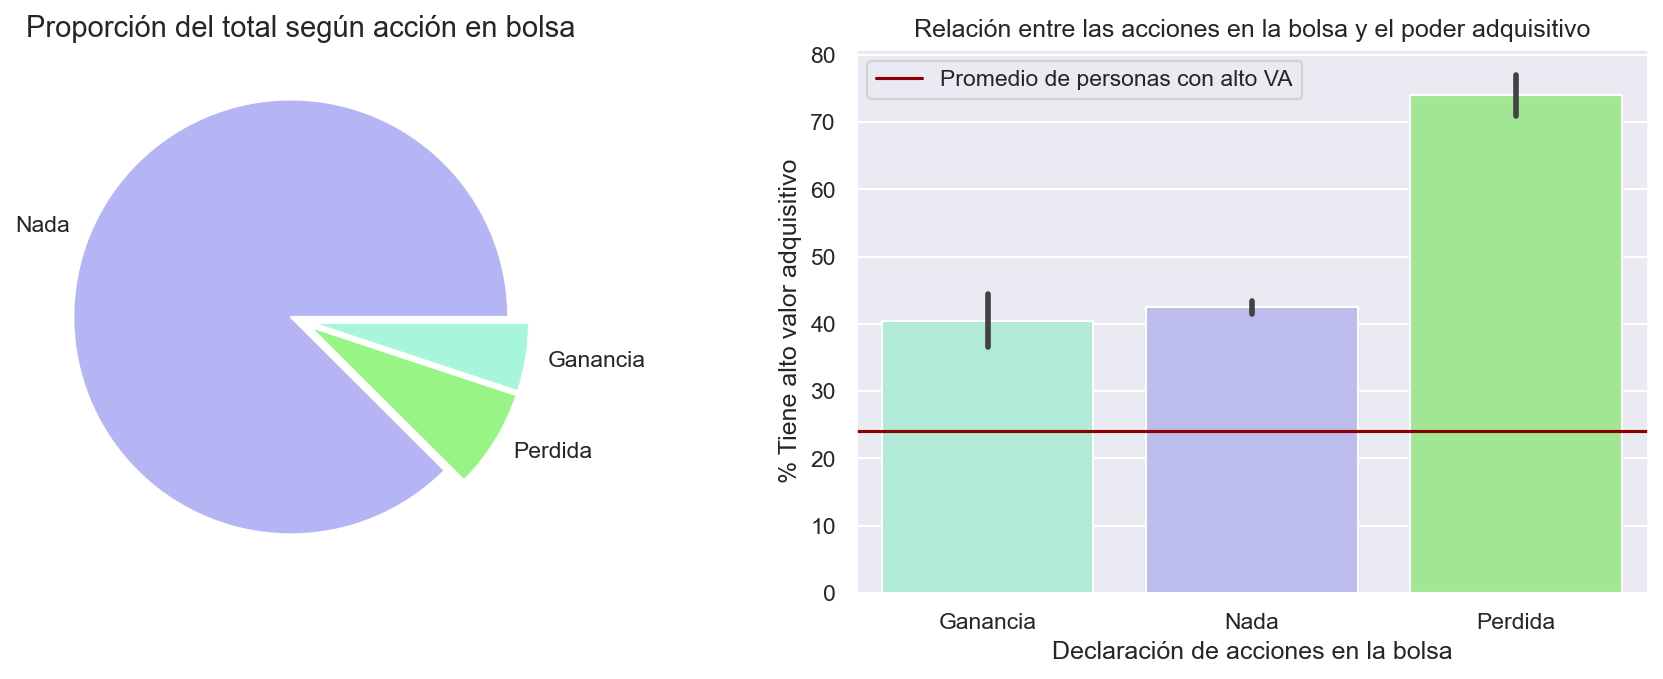

In [327]:
df_tmp = df_pipeline[['ganancia_perdida_declarada_bolsa_argentina', 'tiene_alto_valor_adquisitivo']].copy()
df_tmp['bolsa'] = df_tmp['ganancia_perdida_declarada_bolsa_argentina'].apply(designar_accion)
del df_tmp['ganancia_perdida_declarada_bolsa_argentina']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))
color_nada = '#B5B5F5'
color_perdida = '#98F585' 
color_ganancia = '#A7F5DA'
labels = df_tmp['bolsa'].value_counts().keys()
ax1.pie(
    x=df_tmp['bolsa'].value_counts(),
    explode=[0.05]*3,
    labels=labels,
    pctdistance=0.5,
    colors = [color_nada, color_perdida, color_ganancia]
)
ax1.set_title("Proporción del total según acción en bolsa", fontsize=14);
sns.barplot(
    data=df_tmp,
    x='bolsa',
    y='tiene_alto_valor_adquisitivo',
    ax=ax2,
    estimator=lambda x: np.mean(x)*100.0,
    order = ['Ganancia', 'Nada', 'Perdida'],
    palette = [ color_ganancia, color_nada, color_perdida]
)
ax2.set_ylabel("% Tiene alto valor adquisitivo")
ax2.set_xlabel("Declaración de acciones en la bolsa")
ax2.set_title('Relación entre las acciones en la bolsa y el poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axhline(prom, color="darkred", label="Promedio de personas con alto VA")
ax2.legend()
plt.show()

Vemos que se pueden filtrar aún suficiente cantidad de gente cuyo valor adquisitivo es alto, estos son aquellos que declararon pérdidas en la bolsa.

Por lo que:

In [329]:
df_pipeline = df_pipeline[df_pipeline['ganancia_perdida_declarada_bolsa_argentina'] >= 0]

Otra cualidad que vimos interesante para predecir la variable objetivo se trata de la cantidad de años estudiados, veamos cómo se comporta a esta altura:

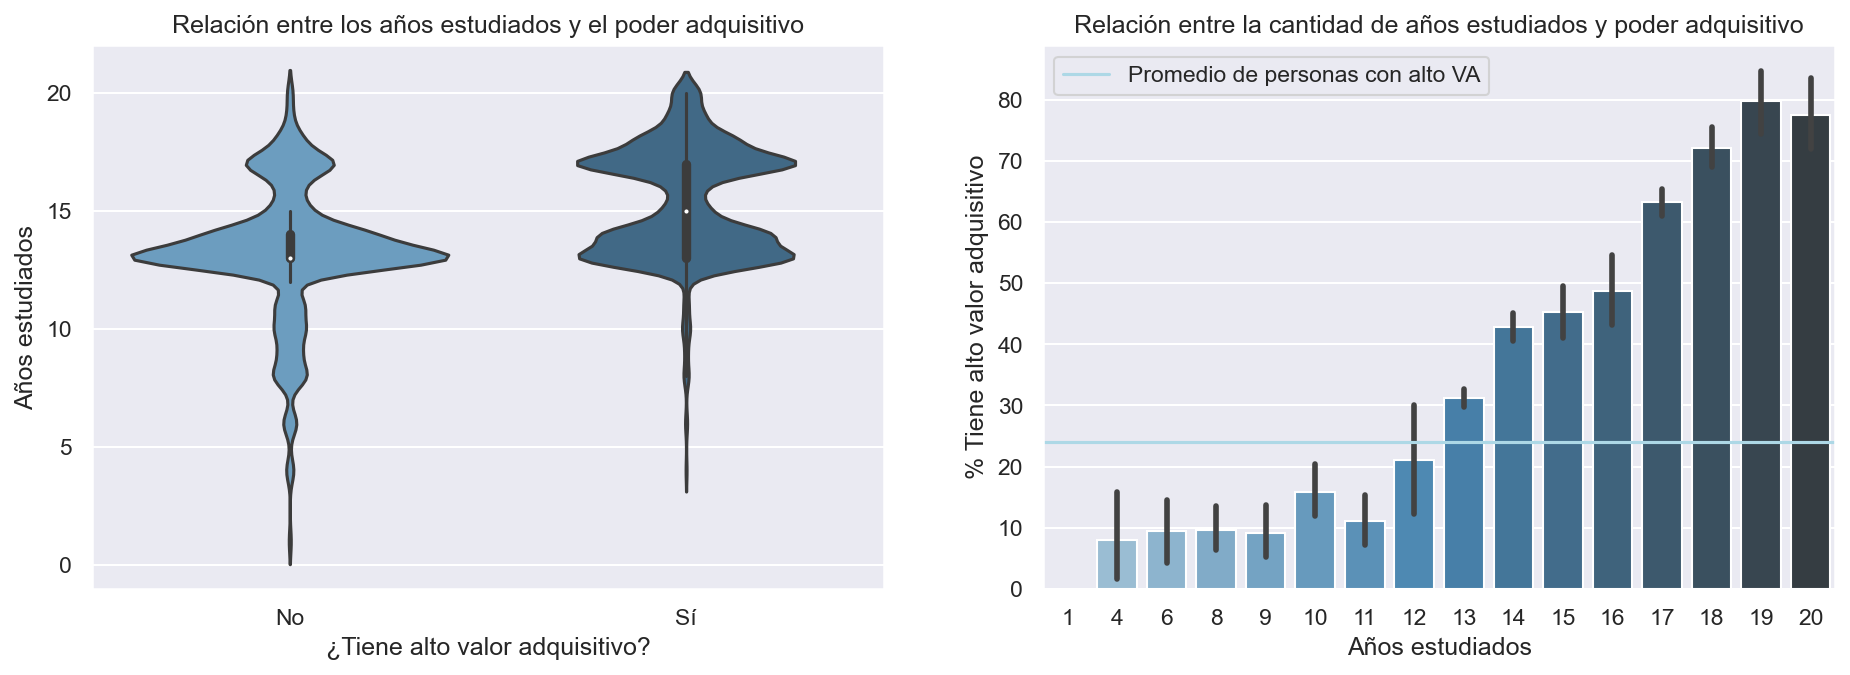

In [331]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(7.5 * 2, 4.8))

df_tmp = df_pipeline[['anios_estudiados', 'tiene_alto_valor_adquisitivo']].copy()

ax1.set_title("Relación entre los años estudiados y el poder adquisitivo")
sns.violinplot(
    data=df_tmp,
    x='tiene_alto_valor_adquisitivo',
    y='anios_estudiados',
    ax=ax1,
    palette="Blues_d"
)
ax1.tick_params(which='both', width=2)
ax1.set_ylabel("Años estudiados")
ax1.set_xlabel("¿Tiene alto valor adquisitivo?")
ax1.set_xticklabels(labels=["No", "Sí"])

sns.barplot(
    data=df_tmp,
    palette="Blues_d",
    x='anios_estudiados',
    y='tiene_alto_valor_adquisitivo',
    ax=ax2,
    estimator = lambda x: np.mean(x)*100.0
)

ax2.set_ylabel("% Tiene alto valor adquisitivo")
ax2.set_xlabel("Años estudiados")
ax2.set_title('Relación entre la cantidad de años estudiados y poder adquisitivo')
prom = df['tiene_alto_valor_adquisitivo'].mean()*100.0
ax2.axhline(prom, color="lightblue", label="Promedio de personas con alto VA")
ax2.legend()

plt.show()

Por lo que, clasificaremos como bajo poder adquisitivo a aquella gente que tuvo 12 o menos años estudiados, y en contrapartida clasificaremos como alto poder adquisitivo a aquella gente que tuvo 17 o más años estudiados.

Por lo que:

In [348]:
df_pipeline = df_pipeline[(df_pipeline['anios_estudiados'] >= 13) & (df_pipeline['anios_estudiados'] <= 16)]

In [360]:
def baseline_aux(row):
    if(row['ganancia_perdida_declarada_bolsa_argentina'] > 7000):
        return 1
    if(row['edad'] <= 30 or row['edad'] > 70):
        return 0
    else:
        if(row['rol_familiar_registrado'] != 'casado'):
            return 0
        else:
            if(row['ganancia_perdida_declarada_bolsa_argentina'] < 0):
                return 1
            else:
                if(row['anios_estudiados'] >= 17):
                    return 1
                elif(row['anios_estudiados'] <= 12):
                    return 0
                else:
                    # Hay que seguir laburandola quiza... son 6350 personas...
                    return 0
def baseline(df):
    return df.apply(baseline_aux, axis=1)

np.mean(df['tiene_alto_valor_adquisitivo'] == baseline(df))

0.8445352337654359

## Conclusión